# **In Pursuit of Direct Democracy: Analyzing Predictors of U.S. State Ballot Measure Support and Roll-off**

For this project, I scrape online elections data on U.S. state ballot measures, including ballot text and campaign finance, as well as state demographic and historical electoral data, to create a predictive model for ballot measure support and roll-off.

I employed an array of skills for this project, including web scraping, data cleaning, text analysis, data analysis, data visualization, and machine learning models.

**Packages used:** Beautiful Soup, Selenium, Regular Expressions, pandas, Scikit-learn, Matplotlib, statsmodels, Stargazer

All data sources are cited at the end of this notebook.

## **Load Packages**

In [ ]:
import requests
import time
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import ast

## **Ballot Measure Scrape**

Below, I scrape Ballotpedia with Beautiful Soup for data on all U.S. state ballot measures from 2004 to 2024.

In [ ]:
def get_measure_link(columns):
    '''
    Get ballot measure link from ballot measure table

    columns - list of ballot measure table columns HTML

    Returns ballot measure link as string
    '''
    measurelink = columns[1].a['href']
    if measurelink.startswith('/'):
        measurelink = 'https://ballotpedia.org' + measurelink
    return measurelink

def get_state(slug):
    '''
    Get state from ballot measure slug

    slug - string URL slug of ballot measure

    Returns state as string
    '''
    if slug[0] in ('New', 'North', 'Rhode', 'South', 'West'):
        return slug[0] + ' ' + slug[1]
    return slug[0]

def get_subjects(columns, col_idx):
    '''
    Get ballot measure subjects from ballot measure table

    columns - list of ballot measure table columns HTML
    col_idx - integer index of subjects column

    Returns subjects as list
    '''
    return [subjtag.text.strip() for subjtag in columns[col_idx].find_all('a')]

def get_approval(columns, col_idx):
    '''
    Determine whether ballot measure was approved from ballot measure table

    columns - list of ballot measure table columns HTML
    col_idx - integer index of approval column

    Returns approval status as Boolean
    '''
    if columns[col_idx].a is not None:
        return columns[col_idx].a['title'] in ('Approved', 'Repealed, altered, or partially repealed')
    return False

year = []
state = []
title = []
measuretype = []
subject = []
concluded = []
approved = []
link = []

In [ ]:
# retrive Ballotpedia ballot measure page HTML for each year in range of interest
for pageyear in range(2004, 2025):
    r = requests.get(f'https://ballotpedia.org/{pageyear}_ballot_measures')
    soup = BeautifulSoup(r.content, 'lxml')
    # find table for each state's ballot measures that year
    for table in soup.find_all('table', class_ = 'bptable', attrs = {'style' : 'width:auto;'}):
        # skip tables not representing states
        if 'sortable' in table['class']:
            if table.tbody.tr.th.text.strip() != 'Type':
                continue
        # iterate through rows, each representing one ballot measure
        for row in table.tbody.find_all('tr'):
            columns = row.find_all('td')
            if columns:
                # get ballot measure link
                measure_link = get_measure_link(columns)
                # get ballot measure data, skipping tables not representing states
                if not (pageyear == 2022 and columns[1].a['href'].startswith('/')):
                    year.append(pageyear)
                    link.append(measure_link)
                    slug = measure_link.split('/')[3].split('_')
                    state.append(get_state(slug))
                    measuretype.append(columns[0].text.strip())
                    title.append(columns[1].text.strip())
                    # get ballot measures subject(s)/conclusion status/approval status based on presence in table
                    if len(columns) in (5, 7):
                        subject.append(get_subjects(columns, 2))
                        concluded.append(True)
                        approved.append(get_approval(columns, 4))
                    elif len(columns) == 6:
                        subject.append([])
                        concluded.append(True)
                        approved.append(get_approval(columns, 3))
                    else:
                        concluded.append(False)
                        approved.append(None)
                        subject.append(get_subjects(columns, 2) if len(columns) == 4 else [])
    time.sleep(5)

In [ ]:
# create pandas DataFrame of all metrics
bal_measures = pd.DataFrame([year, state, title, measuretype, subject, concluded, approved, link]).transpose()
bal_measures.columns = ['Year', 'State', 'Title', 'Type', 'Subject(s)', 'Concluded', 'Approved', 'Link']
# exclude territories/districts
bal_measures = bal_measures[~bal_measures['State'].isin(('American', 'El', 'Puerto', 'U.S.', 'Washington,'))]
# remove measures w/ ambiguous yes vs no options
ambig_row_idx = bal_measures.loc[(bal_measures['Approved'] != True) & (bal_measures['Approved'] != False) & (bal_measures['Year'] != 2024)].index
bal_measures.drop(ambig_row_idx, inplace = True)
# clean typos
bal_measures.loc[bal_measures['State'] == 'West Virginia,', 'State'] = 'West Virginia'
# reset index
bal_measures.reset_index(drop = True, inplace = True)

In [ ]:
# create DataFrame copy
bal_measures_copy = bal_measures.copy()
# cast 'Subject(s)' as string to verify table has no duplicates
bal_measures_copy['Subject(s)'] = str(bal_measures_copy['Subject(s)'])
len(bal_measures_copy.drop_duplicates()) == len(bal_measures)

True

## **Ballot Text Scrape**

Using the Ballotpedia links obtained in the last scrape, I now scrape for the final vote counts and official text of all ballot measures in my dataset.

In [ ]:
bal_measures = pd.read_csv('bal_measures.csv')

In [ ]:
def get_ballot_text(heading_text_options, tag, target_list):
    '''
    Appends specified list with text of ballot measure

    heading_text_options - list of strings, each representing potential heading for text section
    tag - string representing HTML tag of heading
    target_list - list to append text to
    '''
    heading = soup.find(tag, string = heading_text_options[0])
    counter = 1
    # test different heading options
    while heading is None and len(heading_text_options) > counter:
        heading = soup.find(tag, heading_text_options[counter])
        counter += 1
    # if text section found, get each line of ballot text
    if heading is not None:
        text_lines = []
        text_block = heading.findNext(['table', 'blockquote'])
        for line in text_block.find_all(['p', 'li', 'i', 'td']):
            # if td tag, check for child tags
            if line.name == 'td' and line.find_all(['p', 'li', 'i']) != []:
                for child in line.find_all(['p', 'li', 'i']):
                    # add child text to ballot text list
                    if child.text not in text_lines:
                        text_lines.append(child.text)
            # otherwise add line text to ballot text list
            elif line.text not in text_lines:
                text_lines.append(line.text)
        # append to target list
        target_list.append(' '.join(text_lines))
    else:
        target_list.append(None)

ballot_title = []
ballot_summary = []
fiscal_impact = []
yes_votes = []
no_votes = []

In [ ]:
# iterate through each link for ballot measures in DataFrame
for idx, row in bal_measures[bal_measures['Concluded'] == True].iterrows():
    measure_link = row['Link']
    # progress tracker
    print(idx)
    # request Ballotpedia ballot measure page
    r = requests.get(measure_link)
    soup = BeautifulSoup(r.content, 'lxml')
    # get ballot text for each text type (title/question, summary, fiscal impact statement)
    get_ballot_text(['Ballot title', 'Ballot question', 'Title', 'Ballot language'], 'h3', ballot_title)
    get_ballot_text(['Ballot summary', 'Petition summary', 'Official description'], 'h3', ballot_summary)
    get_ballot_text(['Fiscal impact statement'], 'h3', fiscal_impact)

    # if text section lacks subheading(s), get general ballot text as title
    if ballot_title[-1] == None and ballot_summary[-1] == None:
        ballot_title.pop(-1)
        get_ballot_text(['Text of measure'], 'h2', ballot_title)

    # get yes/no vote counts from outcome table
    result_rows = soup.find('table', attrs = {'border' : '1'})
    first_vote_count = result_rows.find(['td', 'b'], string = re.compile('^ *[0-9]+,?[0-9]*,?[0-9]* *$'))
    second_vote_count = first_vote_count.findNext('tr').find_all('td')[1]
    # determine which vote count represents yes vs no to append count to correct list
    if re.search('Yes', first_vote_count.findPrevious('td', attrs = {'colspan' : '2'}).text):
        yes_votes.append(float(first_vote_count.text.strip().replace(',', '')))
        no_votes.append(float(second_vote_count.text.strip().replace(',', '')))
    else:
        yes_votes.append(float(second_vote_count.text.strip().replace(',', '')))
        no_votes.append(float(first_vote_count.text.strip().replace(',', '')))

    time.sleep(5)

In [ ]:
# get links of concluded ballot measures
concl_links = bal_measures[bal_measures['Concluded'] == True]['Link']

# create pandas DataFrame of ballot text and yes/no vote counts
text_scrape = pd.DataFrame([ballot_title, ballot_summary, fiscal_impact, yes_votes, no_votes, concl_links]).transpose()
text_scrape.columns = ['Title_text', 'Summary_text', 'Fiscal_impact_text', 'Yes_votes', 'No_votes', 'Link']

In [ ]:
bal_measures.set_index('Link')
text_scrape.set_index('Link')
text_scrape.drop_duplicates(inplace = True)

# combine ballot measure info DataFrame with ballot text/vote count DataFrame
bal_final = bal_measures.merge(text_scrape, on = 'Link', how = 'left')

In [ ]:
# find measures where wrong table scraped for yes/no vote counts
bal_final[bal_final['Yes_votes'] < bal_final['No_votes']][bal_final['Approved'] == True]['Link']

# 956, 1380, 1381, 1383, 1384,1390, 1403, 1561 scraped wrong tables

<ipython-input-127-3a00180b7650>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bal_final[bal_final['Yes_votes'] < bal_final['No_votes']][bal_final['Approved'] == True]['Link']


956    https://ballotpedia.org/Georgia_Sales_Tax_Incr...
Name: Link, dtype: object

In [ ]:
# manually visit pages and recode vote counts
bal_final.loc[956, 'Yes_votes'], bal_final.loc[956, 'No_votes'] = 622316, 887957
bal_final.loc[1380, 'Yes_votes'], bal_final.loc[1380, 'No_votes'] = 381768, 377773
bal_final.loc[1381, 'Yes_votes'], bal_final.loc[1381, 'No_votes'] = 383428, 373848
bal_final.loc[1383, 'Yes_votes'], bal_final.loc[1383, 'No_votes'] = 420892, 337486
bal_final.loc[1384, 'Yes_votes'], bal_final.loc[1384, 'No_votes'] = 388273, 356621
bal_final.loc[1390, 'Yes_votes'], bal_final.loc[1390, 'No_votes'] = 1769328, 1528219
bal_final.loc[1403, 'Yes_votes'], bal_final.loc[1403, 'No_votes'] = 558631, 548732
bal_final.loc[1561, 'Yes_votes'], bal_final.loc[1561, 'No_votes'] = 365107, 237567

In [ ]:
# convert U.S. state names to two-letter abbreviations

# dictionary sourced from https://gist.github.com/rogerallen/1583593
us_state_to_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI',
    'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
    'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'United States': 'US', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia': 'DC',
    'American Samoa': 'AS', 'Guam': 'GU', 'Northern Mariana Islands': 'MP',
    'Puerto Rico': 'PR', 'United States Minor Outlying Islands': 'UM',
    'U.S. Virgin Islands': 'VI',
}

bal_final['State'] = bal_final['State'].map(us_state_to_abbrev)

In [ ]:
bal_final.to_csv('bal_final.csv', index = False)

In [ ]:
bal_final.head()

,Year,State,Title,Type,Subject(s),Concluded,Approved,Link,Title_text,Summary_text,Fiscal_impact_text,Yes_votes,No_votes
0,2004,AL,Amendment 1,LRCA,['Development'],True,True,https://ballotpedia.org/Alabama_Industrial_Dev...,\n Proposing an amendment to the Constitution ...,None,None,674466.0,535786.0
1,2004,AL,Amendment 2,LRCA,['Con Language'],True,False,https://ballotpedia.org/Alabama_Separation_of_...,\n Proposing an amendment to the Constitution ...,None,None,689450.0,691300.0
2,2004,AL,Amendment 3,LRCA,['Development'],True,True,https://ballotpedia.org/Alabama_Economic_and_I...,\n Proposing an amendment to the Constitution ...,None,None,727630.0,584014.0
3,2004,AL,Amendment 4,LRCA,['Development'],True,True,https://ballotpedia.org/Alabama_Shrimp_and_Sea...,\n Proposing an amendment to the Constitution ...,None,None,815629.0,479767.0
4,2004,AL,Amendment 5,LRCA,"[""Local Gov't""]",True,False,https://ballotpedia.org/Alabama_Trussville_Ann...,\n Relating to the City of Trussville in Jeffe...,None,None,505628.0,623920.0


## **Ballot Text Cleaning & Feature Engineering**

Given the ballot measure text I was able to scrape, I extract the actual ballot text and tokenize words to calculate ballot word length, reading complexity, and other text accessibility features.

In [ ]:
# dtype = {'Year': 'int', 'State': 'str', 'Title': 'str', 'Type': 'str', 'Subject(s)': 'str', 'Concluded': 'bool', 'Approved': 'bool', 'Link': 'str', 'Title_text': 'str', 'Summary_text': 'str', 'Fiscal_impact_text': 'str', 'Yes_votes': 'float', 'No_votes': 'float'}
# import CSV for future use
bal_final = pd.read_csv('bal_final.csv')
# convert subject(s) from strings back to lists
bal_final['Subject(s)'] = bal_final['Subject(s)'].apply(lambda x: ast.literal_eval(x))

In [ ]:
text_cols = bal_final.iloc[:,-5:-2].astype(str)
# clear mis-scraped text (doesn't represent ballot text)
text_cols = text_cols.map(lambda x : '' if ('Suggest a link' in x) or
 (x.endswith('Total')) or ('percent -' in x) or ('•' in x) or
  ('Position is ahead and at or over 50%' in x) or ('Taxation \$[0-9]+' in x) or
   ('[0-9]+ percent [0-9]+ percent' in x) or (x == '“\n used.[2]\n ”\n') else x)
# remove leading/trailing whitespace and Ballotpedia's quotation marks
text_cols = text_cols.map(lambda x : x.strip().strip('“”"'))
# remove footnotes and newline sequences
text_cols = text_cols.map(lambda x : re.sub('\[[0-9]+\]|\\n', '', x))
# remove outlying whitespace/quotation marks
text_cols = text_cols.map(lambda x : x.strip().strip('“”"'))
# remove yes/no + approve/disapprove choices
text_cols = text_cols.map(lambda x : re.sub('(\[ *\])?(\( *\))?(▢)? *(Approve|Yes|For|Support) *(_+)?(\[ *])?(\( *\))?(▢)? *(Disapprove|No|Against|Oppose) *(_+)?', '', x, flags = re.IGNORECASE))
# strip and remove leading title and explanation labels
text_cols = text_cols.map(lambda x : re.sub('Explanation:|Title:|^EXPLANATION', '', x.strip()))
# remove multiple consecutive spaces
text_cols = text_cols.map(lambda x : re.sub(' {2,}', ' ', x))
# remove outlying parentheses/brackets
text_cols = text_cols.map(lambda x : re.sub('^[\(\[\{].*[\}\]\)]$', '', x))
# remove further mis-scraped text
text_cols = text_cols.map(lambda x : '' if re.match('^Proposed by Act _+$', x) else x)

# convert whitespace/NaN strings to empty strings
text_cols = text_cols.replace('^(\s*|nan|NaN)$|', '', regex = True).astype(object)

# concatenate title and summary text to full measure text column
full_text = text_cols['Title_text'] + ' ' + text_cols['Summary_text']
full_text = full_text.map(lambda x : x.strip())

bal_final.iloc[:,-5:-2] = text_cols.iloc[:,:3]
bal_final['Full_text'] = full_text

In [ ]:
bal_final.to_csv('bal_clean.csv', index = False)

**About Flesch-Kincaid Grade Level:**
https://readable.com/readability/flesch-reading-ease-flesch-kincaid-grade-level/

**py-readability-metrics package:** https://pypi.org/project/py-readability-metrics/

Copyright (c) 2018 Carmine M DiMascio

**textstat package:** https://github.com/textstat/textstat

Copyright (c) 2016 Shivam Bansal (shivam5992@gmail.com)

In [ ]:
# !pip install py-readability-metrics
# !pip install textstat

In [ ]:
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
import nltk
nltk.download('punkt_tab')
from readability import Readability

# tokenize + length
tokenizer = RegexpTokenizer('\w+')
token_text = full_text.map(lambda x : tokenizer.tokenize(x.lower()))
text_lens = token_text.map(lambda x : len(x))

# remove non-text
full_text[text_lens.index[text_lens <= 3]] = ''

# question format
is_question = full_text.map(lambda x : True if '?' in x else False)

# more than one sentence long
is_multi_sentence = full_text.map(lambda x : True if '. ' in x else False)

# fiscal statement
has_fiscal = bal_final['Fiscal_impact_text'] != ''

# complexity
fk_grades = full_text.map(
    lambda x : pd.to_numeric(Readability(x).flesch_kincaid().grade_level) if (len(tokenizer.tokenize(x.lower())) > 103) else np.nan)

text_analysis = pd.DataFrame([text_lens, is_question, is_multi_sentence, has_fiscal, fk_grades]).transpose()
text_analysis.columns = ['text_len', 'is_question', 'is_multi_sentence', 'has_fiscal', 'fk_grade']
text_analysis.to_csv('text_analysis.csv', index = False)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
print('Max Difficulty: ' + str(fk_grades.loc[fk_grades.notna()].max()))
print('Min Difficulty: ' + str(fk_grades.loc[fk_grades.notna()].min()))

Max Difficulty: 344.0
Min Difficulty: 6.0


## **Campaign Finance Scrape**

Below, I scrape OpenSecrets.com with Selenium for data on money raised for issue campaigns in support for and  oppositions to specific ballot measures.

In [ ]:
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver = uc.Chrome(headless = False, use_subprocess = False)

measures = []

# basic ballot measure info and link scraper
for year in range(2004, 2025):
    # retrieve year's ballot measure fundraising dataset
    driver.get(f'https://www.opensecrets.org/ballot-measures/{year}')
    # when loaded, identify number of pages of ballots to scrape
    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="DataTables_Table_0_next"]')))
    last_page = int(driver.find_elements(By.XPATH, '//*[@id="DataTables_Table_0_paginate"]/span/a')[-1].text)
    # for each page, find next button and scrape table of measures
    for page_num in range(last_page):
        next_button = driver.find_element(By.XPATH, '//*[@id="DataTables_Table_0_next"]')
        measure_table = driver.find_element(By.XPATH, '//*[@id="DataTables_Table_0"]/tbody')
        # for each table of measures, scrape measure link, title, and state
        for row in measure_table.find_elements(By.TAG_NAME, 'tr'):
            measure = row.find_element(By.TAG_NAME, 'a')
            measure_title = measure.text.split(' : ')[0].split(' (')[0]
            measure_link = measure.get_attribute('href')
            measure_state = measure_link.split('/')[4]
            measures.append([year, measure_state, measure_title, measure_link])
        next_button.click()

In [ ]:
# ballot measure fundraising dollar amount scraper
for measure in measures:
    support = 0
    oppose = 0
    # for each measure in dataset, find fundraising table
    driver.get(measure[3])
    tables = driver.find_elements(By.XPATH, '//*[@id="DataTables_Table_0"]/tbody')
    # given at least one interest group, identify support rows and oppose rows
    if len(tables) != 0:
        finance_table = tables[0]
        for row in finance_table.find_elements(By.TAG_NAME, 'tr'):
            sup_or_opp = row.find_elements(By.TAG_NAME, 'td')[1].text
            # convert dollars to numeric type and sum support dollars and oppose dollars
            raised = float(row.find_elements(By.TAG_NAME, 'td')[2].text.replace('$', '').replace(',', ''))
            if sup_or_opp == 'Support':
                support += raised
            else:
                oppose += raised
        measure.append(support)
        measure.append(oppose)

driver.quit()

In [ ]:
finance = pd.DataFrame(measures, columns = ['Year', 'State', 'Title', 'Link', 'Support_dollars', 'Oppose_dollars'])
finance.fillna(0, inplace = True)
finance.to_csv('finance.csv', index = False)

## **State Partisanship Scrape**

To measure state partisanship, I operationalize partisanship in a given year as the party affiliation of the current state-specific officeholders last voted in by the state: state governor, majority of U.S. Senators, majority of U.S. Representatives, as well as the state's last majority vote for U.S. President. Each of these four offices contributes a quarter of the year's partisanship score.

Partisanship scores range from -1.0 (most Democratic) to 1.0 (most Republican). Independent officeholders and split offices (e.g., 1 Democratic and 1 Republican Senator) count as a point in neither direction.

Example:
Democratic governor (-.25) + Split Senators (.00) + Majority Republican Representatives (.25) + Last voted Republican president (.25) = .25 partisanship score for year

In [ ]:
def get_data_tables(url):
    '''
    Get data table for each state from webpage

    url - string representing URL of page to scrape

    Returns list of HTML tables, each representing one state
    '''
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'lxml')
    states = soup.find_all('h3', string = re.compile('[A-Za-z^(Washington, D.C.)]'))[:50]
    return [(state.text.strip(), state.findNext('table')) for state in states]

In [ ]:
pres_tables = get_data_tables('https://ballotpedia.org/Presidential_voting_history_by_state')
trifecta_tables = get_data_tables('https://ballotpedia.org/Historical_and_potential_changes_in_trifectas')

partisanship_dic = {}

# add key-value pair of state and historical partisanship scores from 2004-2024 for each state
for state in range(50):
    state_scores = []
    votes_by_year = []

    # presidential vote tracker
    pres_votes = pres_tables[state][1].find_all('tr')[1]
    pres_year_counter = 2004
    for pres_year in pres_votes.find_all('td')[27:]:
        # append vote list with vote for number of years vote was most recent
        if pres_year_counter == 2020:
            reps = 5
        else:
            reps = 4
        for _ in range(reps):
            votes_by_year.append([pres_year.text.strip()])
        pres_year_counter += 4

    # governor, senate, house officeholder trifecta
    trifecta_offices = trifecta_tables[state][1].find_all('tr')[1:]
    # for each state office, append vote list with party of that year's officeholders
    for office in trifecta_offices:
        office_votes = office.find_all('td')[13:]
        for office_year in range(len(votes_by_year)):
             office_vote = office_votes[office_year].text.strip()
             votes_by_year[office_year].append(office_vote)

    # convert vote lists to partisanship scores
    for year in votes_by_year:
        year_score = 0
        for vote in year:
            if vote == 'R':
                year_score += 1/4
            elif vote == 'D':
                year_score -= 1/4
        state_scores.append(year_score)

    partisanship_dic[pres_tables[state][0]] = state_scores

partisanship = pd.DataFrame().from_dict(partisanship_dic, orient = 'index')
partisanship = partisanship.reset_index()
partisanship.columns = ['State'] + [year for year in range(2004, 2025)]

In [ ]:
partisanship

,State,2004,2005,2006,2007,2008,2009,2010,2011,2012,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Alabama,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0
1,Alaska,1.00,1.00,1.00,0.50,0.50,0.50,0.50,0.50,0.50,...,0.75,0.75,0.25,0.25,0.75,0.75,0.75,0.75,0.5,0.5
2,Arizona,0.50,0.50,0.50,0.50,0.50,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,0.50,0.50,0.50,0.0,0.0
3,Arkansas,0.00,0.00,0.00,-0.50,-0.50,-0.50,-0.50,-0.50,-0.50,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0
4,California,-0.50,-0.50,-0.50,-0.50,-0.50,-0.50,-0.50,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0
5,Colorado,1.00,0.00,0.00,-0.50,-1.00,-1.00,-1.00,-0.50,-0.50,...,-0.50,-0.50,-0.50,-0.50,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0
6,Connecticut,-0.50,-0.50,-0.50,-0.50,-0.50,-0.50,-0.50,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0
7,Delaware,-0.50,-0.50,-0.50,-0.50,-0.50,-1.00,-1.00,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0
8,Florida,1.00,1.00,1.00,1.00,0.50,0.50,0.25,0.50,0.50,...,0.50,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0
9,Georgia,0.50,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,0.50,0.50,0.50,0.5,0.5


In [ ]:
# convert states to postal abbreviations
partisanship['State'] = partisanship['State'].map(us_state_to_abbrev)

In [ ]:
# melt DataFrame to long form
partisanship = partisanship.melt(id_vars = 'State', var_name = 'Year', value_name = 'Partisanship')
partisanship

,State,Year,Partisanship
0,AL,2004,0.0
1,AK,2004,1.0
2,AZ,2004,0.5
3,AR,2004,0.0
4,CA,2004,-0.5
...,...,...,...
945,VA,2022,0.0
946,WA,2022,-1.0
947,WV,2022,1.0
948,WI,2022,0.0


In [ ]:
partisanship.to_csv('partisanship.csv', index = False)

## **Voter Turnout Scrape**

I scrape voter turnout data for each U.S. state from 2004 to 2024, linearly imputing missing values.

In [ ]:
r = requests.get('https://ballotpedia.org/Voter_turnout_in_United_States_elections')
soup = BeautifulSoup(r.content, 'lxml')

turnout_table = soup.find_all('table', class_ = 'wikitable')[1]
turnout_data = []

# for each state, append turnout data list with list of recorded voter turnout from 2022 to 2004
for state in turnout_table.find_all(['tr'])[1:54]:
    turnout_data.append([cell.text.strip() for cell in state.find_all(['td', 'th'])[:-1]])

turnout = pd.DataFrame(turnout_data[1:], columns = turnout_data[0])
turnout.replace(['NA', 'N/A'], np.nan, inplace=True)

# clean turnout data to floating-point numbers
turnout = turnout.astype(str)
for col_idx in range(1, len(turnout.columns)):
    turnout.iloc[:,col_idx] = turnout.iloc[:,col_idx].str.rstrip('%').astype('float') / 100

turnout

,State,2024,2022,2020,2018,2016,2014,2012,2010,2008,2006,2004
0,Alabama,0.589,0.373,0.618,0.47,0.591,0.332,NaN,0.433,0.61,NaN,0.574
1,Alaska,0.569,0.502,0.684,0.548,0.615,0.548,0.589,0.529,0.683,0.512,0.696
2,Arizona,0.636,0.493,0.686,0.474,0.561,0.341,0.53,0.416,0.574,0.396,0.548
3,Arkansas,0.535,0.415,0.565,0.413,0.532,0.403,0.511,0.379,0.529,0.389,0.544
4,California,0.625,0.429,0.686,0.493,0.582,0.307,0.557,0.459,0.617,0.412,0.596
5,Colorado,0.731,0.583,0.776,0.614,0.719,0.547,0.706,0.517,0.716,0.481,0.673
6,Connecticut,0.671,0.486,0.707,0.548,0.649,0.425,0.614,0.459,NaN,0.477,0.662
7,Delaware,0.67,0.428,0.701,0.512,0.644,0.349,NaN,0.49,0.658,0.429,0.645
8,District of Columbia,0.636,0.406,0.658,0.437,0.607,0.357,0.616,0.296,0.617,0.287,0.549
9,Florida,0.667,0.481,0.723,0.543,0.656,0.433,0.633,0.422,0.666,0.401,0.647


In [ ]:
# convert states to postal abbreviations
turnout['State'] = turnout['State'].map(us_state_to_abbrev)

In [ ]:
# fill scores for missing years using linear interpolation
# reindex DataFrame to include missing years
turnout = turnout.set_index('State')
all_years = range(2004, 2023)
turnout.columns = turnout.columns.astype(float)
turnout = turnout.reindex(columns = all_years)

# linearly interpolate all missing turnout rates
turnout = turnout.astype(float)
turnout = turnout.interpolate(method = 'linear', axis = 1, limit_direction = 'both')

# reset index
turnout = turnout.reset_index()

turnout

,State,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AL,0.574,0.58300,0.5920,0.60100,0.610,0.5215,0.433,0.407750,0.382500,0.35725,0.332000,0.461500,0.5910,0.53050,0.470,0.5440,0.618,0.4955,0.373
1,AK,0.696,0.60400,0.5120,0.59750,0.683,0.6060,0.529,0.559000,0.589000,0.56850,0.548000,0.581500,0.6150,0.58150,0.548,0.6160,0.684,0.5930,0.502
2,AZ,0.548,0.47200,0.3960,0.48500,0.574,0.4950,0.416,0.473000,0.530000,0.43550,0.341000,0.451000,0.5610,0.51750,0.474,0.5800,0.686,0.5895,0.493
3,AR,0.544,0.46650,0.3890,0.45900,0.529,0.4540,0.379,0.445000,0.511000,0.45700,0.403000,0.467500,0.5320,0.47250,0.413,0.4890,0.565,0.4900,0.415
4,CA,0.596,0.50400,0.4120,0.51450,0.617,0.5380,0.459,0.508000,0.557000,0.43200,0.307000,0.444500,0.5820,0.53750,0.493,0.5895,0.686,0.5575,0.429
5,CO,0.673,0.57700,0.4810,0.59850,0.716,0.6165,0.517,0.611500,0.706000,0.62650,0.547000,0.633000,0.7190,0.66650,0.614,0.6950,0.776,0.6795,0.583
6,CT,0.662,0.56950,0.4770,0.47250,0.468,0.4635,0.459,0.536500,0.614000,0.51950,0.425000,0.537000,0.6490,0.59850,0.548,0.6275,0.707,0.5965,0.486
7,DE,0.645,0.53700,0.4290,0.54350,0.658,0.5740,0.490,0.454750,0.419500,0.38425,0.349000,0.496500,0.6440,0.57800,0.512,0.6065,0.701,0.5645,0.428
8,DC,0.549,0.41800,0.2870,0.45200,0.617,0.4565,0.296,0.456000,0.616000,0.48650,0.357000,0.482000,0.6070,0.52200,0.437,0.5475,0.658,0.5320,0.406
9,FL,0.647,0.52400,0.4010,0.53350,0.666,0.5440,0.422,0.527500,0.633000,0.53300,0.433000,0.544500,0.6560,0.59950,0.543,0.6330,0.723,0.6020,0.481


In [ ]:
# melt DataFrame to long form
turnout = turnout.melt(id_vars = 'State', var_name = 'Year', value_name = 'Turnout')
turnout

,State,Year,Turnout
0,AL,2004,0.574
1,AK,2004,0.696
2,AZ,2004,0.548
3,AR,2004,0.544
4,CA,2004,0.596
...,...,...,...
983,WA,2022,0.553
984,WV,2022,0.354
985,WI,2022,0.598
986,WY,2022,0.456


In [ ]:
turnout.to_csv('turnout.csv', index = False)

## **Cost of Voting Index Cleaning**

Given online and publicly downloadable COVI data, I pull relevant columns and use linear imputation to fill missing year values.

In [ ]:
covi = pd.read_excel('covi.xlsx').iloc[:,[1,2,5]]
covi

,state,year,FinalCOVI
0,AL,1996,-0.399114
1,AK,1996,0.663697
2,AZ,1996,0.821447
3,AR,1996,0.346197
4,CA,1996,0.530294
...,...,...,...
395,VA,2022,-0.740231
396,WA,2022,-2.450240
397,WV,2022,-0.189976
398,WI,2022,1.231225


In [ ]:
# fill scores for missing years using linear interpolation
# create and merge all state-year combinations for new DataFrame
states = covi['state'].unique()
years = range(covi['year'].min(), covi['year'].max() + 1)
state_years = pd.DataFrame([(state, year) for state in states for year in years],
                           columns = ['state', 'year'])
covi = pd.merge(state_years, covi, on = ['state', 'year'], how = 'left')

# linearly interpolate missing COVI scores
covi['FinalCOVI'] = covi.groupby('state')['FinalCOVI'].transform(lambda x: x.interpolate(method = 'linear'))

covi

,state,year,FinalCOVI
0,AL,1996,-0.399114
1,AL,1997,-0.299212
2,AL,1998,-0.199311
3,AL,1999,-0.099409
4,AL,2000,0.000492
...,...,...,...
1345,WY,2018,0.710421
1346,WY,2019,0.770306
1347,WY,2020,0.830190
1348,WY,2021,1.011098


In [ ]:
# rename COVI column
covi.rename(columns = {'FinalCOVI' : 'COVI'}, inplace = True)

In [ ]:
covi.to_csv('covi.csv', index = False)

## **State Demographics Scrape & Cleaning**

Using publicly downloadable U.S. Census Bureau data from the ACS Demographic and Housing Estimate and ACS Selected Population Profile, I load each year's demographic data into MultiIndex pandas DataFrames, clean messy data, extract potentially relevant columns, and merge them into a master demographics dataset for later analysis.

### Function Definitions

In [ ]:
def read_dem_df(df_name):
    '''
    Reads and cleans Excel file of state demographic data

    df_name - string representing name of Excel file

    Returns pandas DataFrame of state demographic data
    '''
    df = pd.read_excel(f'{df_name}.xlsx', sheet_name = 'Data', header = None).transpose()

    # assign correct column names from first row
    df.columns = df.iloc[0]
    # fill missing measure names
    df.iloc[1:,0] = df.iloc[1:,0].ffill(axis = 0)
    # create pandas MultiIndex from first and second columns
    row_mi = pd.MultiIndex.from_arrays([df.iloc[1:,0], df.iloc[1:,1]], names = ['State', 'Measure'])
    # build data frame with MultiIndex and corresponding values
    values = df.iloc[1:,2:].values
    df_multi = pd.DataFrame(values, index = row_mi, columns = df.columns[2:])

    # find and clean NAs, dropping columns with only NAs
    df_multi.replace('(X)', np.nan, inplace = True)
    df_multi.drop(df_multi.columns[~df_multi.any()], axis = 1, inplace = True)

    # cast all DataFrame values to string type
    df_multi = df_multi.astype(str)
    # clean values and cast back to floats
    df_multi = df_multi.apply(
        lambda col : col.str.rstrip('%').str.replace(',', '').astype(float, errors = 'ignore'))
    df_multi.fillna(np.nan, inplace = True)

    # create year column
    df_multi['Year'] = float('20' + df_name[-2:])

    return df_multi

def read_pop_df(df_name):
    '''
    Reads and cleans Excel file of state selected population data

    df_name - string representing name of Excel file

    Returns pandas DataFrame of state selected population data
    '''
    df = pd.read_excel(f'{df_name}.xlsx', sheet_name = 'Data', header = None).transpose()

    # get upper level column measure indices
    upper_cols = df.columns[~df.iloc[1:].any()]
    # fill missing measure names
    df.iloc[0,0] = 'State'
    # get lower level column measure indices
    lower_cols = df.columns[df.iloc[1:].any()]
    # create list of upper level column names for upper level of pandas MultiIndex
    upper_names = ['']
    for upper_idx in range(len(upper_cols)):
        cur_col = upper_cols[upper_idx]
        # repeat upper level measure name appendage for number of lower level measures within
        if upper_idx != len(upper_cols) - 1:
            for _ in range(upper_cols[upper_idx + 1] - cur_col - 1):
                upper_names.append(df.iloc[0, cur_col])
        else:
            for _ in range(len(df.columns) - cur_col - 1):
                upper_names.append(df.iloc[0, cur_col])
    # create list of lower level names
    lower_names = [df.iloc[0, col] for col in lower_cols]
    # remove unwanted column names
    for _ in range(2):
        lower_names.pop(1)
    # create pandas MultiIndex
    col_mi = pd.MultiIndex.from_arrays([upper_names, lower_names], names = ['Measure', 'Submeasure'])

    # find and clean NAs
    df.replace('(X)', np.nan, inplace=True)
    # drop original upper level columns with only NAs
    df.drop(upper_cols, axis = 1, inplace = True)

    # create pandas DataFrame with new MultiIndex
    values = df.iloc[1:,np.r_[0,3:len(df.columns)]].values

    df_multi = pd.DataFrame(values, columns = col_mi)

    # drop unwanted columns
    df_multi.drop(df_multi.iloc[:,1:3], axis = 1, inplace = True)
    # cast all DataFrame values to string type
    df_multi = df_multi.astype(str)

    # clean values and cast back to floats
    df_multi = df_multi.apply(
        lambda col : col.str.rstrip('%').str.replace(',', '').astype(float, errors = 'ignore'))
    df_multi.fillna(np.nan, inplace = True)

    # create year column
    df_multi['YEAR', 'Year'] = float('20' + df_name[-2:])

    return df_multi

In [ ]:
def clean_dem_df(df):
    # extract raw estimate columns
    est_dem = df.xs(key= 'Estimate', level = 'Measure')[
        ['Year', 'Total population', 'Male', 'Female',
        'Median age (years)', 'Total housing units']]

    # extract percentage columns
    perc_dem = df.xs(key = 'Percent', level = 'Measure')[
        ['White', 'Black or African American', 'American Indian and Alaska Native',
        'Asian', 'Hispanic or Latino (of any race)']]

    # concatenate extracted columns
    df = pd.concat([est_dem, perc_dem], axis = 1)

    # identify duplicate columns to keep first occurrence of
    keep_first = df.columns.isin(['Total population', 'Male', 'Female'])

    # identify duplicate columns to keep last occurrence of
    keep_last = df.columns.isin(['White', 'Black or African American',
                                 'American Indian and Alaska Native',
                                 'Asian', 'Hispanic or Latino (of any race)'])

    # create and apply mask of final column set
    col_mask = (~df.columns.duplicated(keep = False) |
     (~df.columns.duplicated() & keep_first) |
      (~df.columns.duplicated(keep = 'last') & keep_last))
    df = df.loc[:, col_mask]

    # create male to female ratio
    df['Male_to_female'] = df['Male'] / df['Female']
    df.drop(columns = ['Male', 'Female'], inplace = True)

    # convert housing units variable to per capita
    df.loc[:, 'Housing units per capita'] = df['Total housing units'] / df['Total population']
    df.drop(columns = ['Total housing units'], inplace = True)

    # reintroduce state as column
    df.reset_index(inplace = True)

    return df

In [ ]:
def clean_pop_df(df):
    # convert school enrollment variable to per capita
    df['SCHOOL ENROLLMENT', 'Enrolled in school'] = (
        df['SCHOOL ENROLLMENT']['Population 3 years and over enrolled in school'] /
        df['SEX AND AGE']['Total population']) * 100
    # select only demographic columns of interest
    df = pd.concat([
        df['']['State'],
        df['YEAR']['Year'],
        df['HOUSEHOLDS BY TYPE']['Family households'],
        df['MARITAL STATUS']['Now married, except separated'],
        df['SCHOOL ENROLLMENT']['Enrolled in school'],
        df['EDUCATIONAL ATTAINMENT']["Bachelor's degree or higher"],
        df['VETERAN STATUS']['Civilian veteran'],
        df['DISABILITY STATUS']['With a disability'],
        df['LANGUAGE SPOKEN AT HOME AND ABILITY TO SPEAK ENGLISH'][
            ['Language other than English', 'Speak English less than "very well"']],
        df['EMPLOYMENT STATUS']['In labor force'],
        df.loc[:, df.columns.get_level_values(0).str.startswith('INCOME')].droplevel(0, axis = 1)[
            ['Median household income (dollars)', 'Per capita income (dollars)']],
        df['HEALTH INSURANCE COVERAGE']['No health insurance coverage'],
        df['POVERTY RATES FOR FAMILIES AND PEOPLE FOR WHOM POVERTY STATUS IS DETERMINED']['All people']
        ], axis = 1)

    # rename columns for accessibility
    df.rename(columns = {'Now married, except separated': 'Married',
                         'With a disability': 'Has disability',
                         'All people': 'In poverty'}, inplace = True)

    # identify duplicate columns to keep first occurrence of
    keep_first = df.columns.isin(['Married', 'Has disability', 'In labor force'])

    # create and apply mask of final column set
    col_mask = (~df.columns.duplicated(keep = False) | (~df.columns.duplicated() & keep_first))
    df = df.loc[:, col_mask]

    return df

### Reading & Merging All Demographic Data

In [ ]:
import warnings
from pandas.errors import PerformanceWarning

warnings.filterwarnings('ignore', category = PerformanceWarning)

In [ ]:
pd.set_option('future.no_silent_downcasting', True)
# read all ACS demographic tables
dem22 = clean_dem_df(read_dem_df('acsdem22'))
dem21 = clean_dem_df(read_dem_df('acsdem21'))
dem20 = clean_dem_df(read_dem_df('acsdem20'))
dem19 = clean_dem_df(read_dem_df('acsdem19'))
dem18 = clean_dem_df(read_dem_df('acsdem18'))
dem17 = clean_dem_df(read_dem_df('acsdem17'))
dem16 = clean_dem_df(read_dem_df('acsdem16'))
dem15 = clean_dem_df(read_dem_df('acsdem15'))
dem14 = clean_dem_df(read_dem_df('acsdem14'))
dem13 = clean_dem_df(read_dem_df('acsdem13'))
dem12 = clean_dem_df(read_dem_df('acsdem12'))
dem11 = clean_dem_df(read_dem_df('acsdem11'))
dem10 = clean_dem_df(read_dem_df('acsdem10'))

In [ ]:
# read all ACS selected population tables
pop22 = clean_pop_df(read_pop_df('acspop22'))
pop21 = clean_pop_df(read_pop_df('acspop21'))
# 2020 missing from ACS selected population data
pop19 = clean_pop_df(read_pop_df('acspop19'))
pop18 = clean_pop_df(read_pop_df('acspop18'))
pop17 = clean_pop_df(read_pop_df('acspop17'))
pop16 = clean_pop_df(read_pop_df('acspop16'))
pop15 = clean_pop_df(read_pop_df('acspop15'))
pop14 = clean_pop_df(read_pop_df('acspop14'))
pop13 = clean_pop_df(read_pop_df('acspop13'))
pop12 = clean_pop_df(read_pop_df('acspop12'))
pop11 = clean_pop_df(read_pop_df('acspop11'))
pop10 = clean_pop_df(read_pop_df('acspop10'))

In [ ]:
# concatenate all demographic datasets into master datasets
dem_dfs = [dem22, dem21, dem20, dem19, dem18, dem17, dem16, dem15, dem14,
           dem13, dem12, dem11, dem10]
pop_dfs = [pop22, pop21, pop19, pop18, pop17, pop16, pop15, pop14, pop13,
           pop12, pop11, pop10]

dem = pd.concat(dem_dfs, ignore_index = True)
pop = pd.concat(pop_dfs, ignore_index = True)

In [ ]:
# fill missing 2020 data of selected population dataset
# reindex DataFrame to include missing 2020 rows
rows2020 = pd.DataFrame({'State' : pop['State'].unique(), 'Year' : 2020})
pop = pd.concat([pop, rows2020], ignore_index = True)

# sort by state, then by year
pop.sort_values(by = ['State', 'Year'], inplace = True)

# linearly interpolate missing 2020 demographics
pop.infer_objects(copy = False)
pop.iloc[:,1:] = pop.iloc[:,1:].interpolate(method = 'linear', axis = 0,
                                            limit_direction = 'both')

# reset index
pop = pop.reset_index(drop = True)

In [ ]:
# merge demographic and selected population DataFrames
demographics = dem.merge(pop, on = ['State', 'Year'])

# convert states to postal abbreviations
demographics['State'] = demographics['State'].map(us_state_to_abbrev)

In [ ]:
demographics.to_csv('demographics.csv', index = False)

## **Final Dataset Preprocessing**

### Joining Datasets

In [ ]:
# load all datasets with correct types
bal_clean = pd.read_csv('bal_clean.csv', dtype = {
    'Year': 'float64', 'State': 'string', 'Title': 'string', 'Type': 'string',
    'Subject(s)': 'string', 'Concluded': 'float64', 'Approved': 'float64',
    'Link': 'string', 'Title_text': 'string', 'Summary_text': 'string',
    'Fiscal_impact_text': 'string', 'Yes_votes': 'float64',
    'No_votes': 'float64', 'Full_text': 'string'})
covi = pd.read_csv('covi.csv', dtype = {
    'state': 'string', 'year': 'float64', 'COVI': 'float64'})
partisanship = pd.read_csv('partisanship.csv', dtype = {
    'State': 'string', 'Year': 'float64', 'Partisanship': 'float64'})
turnout = pd.read_csv('turnout.csv', dtype = {
    'State': 'string', 'Year': 'float64', 'Turnout' : 'float64'})
finance = pd.read_csv('finance.csv', dtype = {
    'Year': 'float64', 'State': 'string', 'Title': 'string', 'Link': 'string',
    'Support_dollars': 'float64', 'Oppose_dollars': 'float64'})
text_analysis = pd.read_csv('text_analysis.csv', dtype = {
    'text_len': 'float64', 'is_question': 'float64', 'is_multi_sentence': 'float64',
    'has_fiscal': 'float64', 'fk_grade': 'float64'})
demographics = pd.read_csv('demographics.csv', dtype = {
    'State': 'string', 'Year': 'float64', 'Total population': 'float64',
    'Median age (years)': 'float64', 'White': 'float64',
    'Black or African American': 'float64',
    'American Indian and Alaska Native': 'float64', 'Asian' : 'float64',
    'Hispanic or Latino (of any race)': 'float64', 'Male_to_female': 'float64',
    'Housing units per capita': 'float64', 'Family households': 'float64',
    'Married': 'float64', 'Enrolled in school': 'float64',
    "Bachelor's degree or higher": 'float64', 'Civilian veteran': 'float64',
    'Has disability': 'float64', 'Language other than English': 'float64',
    'Speak English less than "very well"': 'float64', 'In labor force': 'float64',
    'Median household income (dollars)': 'float64', 'Per capita income (dollars)': 'float64',
    'No health insurance coverage': 'float64', 'In poverty': 'float64'})

In [ ]:
# merge ballot data with text analysis
ballot = bal_clean.join(text_analysis)

# fill ballot text columns with NAs where text not available
text_cols = ['text_len', 'is_question', 'is_multi_sentence']
ballot.loc[ballot['Full_text'].isna(), text_cols] = np.nan

In [ ]:
# merge cost of voting index
ballot = ballot.merge(covi, left_on = ['State', 'Year'], right_on = ['state', 'year'], how = 'left')
ballot.drop(columns = ['state', 'year'], inplace = True)

# merge turnout
ballot = ballot.merge(turnout, how = 'left')

# merge partisanship
ballot = ballot.merge(partisanship, how = 'left')

# merge demographics
ballot = ballot.merge(demographics, on = ['State', 'Year'], how = 'left')

In [ ]:
# standardize ballot and finance dataset measure titles
# convert to uppercase letters
ballot['Title'] = ballot['Title'].str.upper()
finance['Title'] = finance['Title'].str.upper()

# remove trailing 0s before numbers
ballot['Title'] = ballot['Title'].str.replace(' 0+', ' ', regex = True)
finance['Title'] = finance['Title'].str.replace(' 0+', ' ', regex = True)

# remove rows with same state, year, and title to avoid mismatching
finance = finance[~finance.duplicated(subset = ['State', 'Year', 'Title'],
                                      keep = False)]

# merge campaign finance
ballot = ballot.merge(finance, on = ['Year', 'State', 'Title'], how = 'left', suffixes = ['', '_finance'])

### One-Hot Encoding Subjects

Ballot measure subjects are currently formatted as a list object in the "Subject(s)" column—below, I convert this column into numerous Boolean columns, each representing whether a ballot measure relates to a given subject.

In [ ]:
# one-hot encoding subjects column for analysis
# convert subjects column to list
ballot['Subject(s)'] = ballot['Subject(s)'].apply(ast.literal_eval)

# one-hot encode subjects into separate boolean columns
subjects_onehot = ballot['Subject(s)'].explode().str.get_dummies().groupby(level = 0).sum()

# convert subject column names to lowercase
subjects_onehot.columns = subjects_onehot.columns.str.lower()

# filter columns with regex into smaller list of categories
bonds_rows = subjects_onehot.filter(regex = 'bond')
subjects_onehot['Bonds'] = bonds_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = bonds_rows.columns)

civil_rows = subjects_onehot.filter(regex = 'civil rights|lgbt|race|marriage|affirm|religion|abortion')
subjects_onehot['Civil_rights'] = civil_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = civil_rows.columns)

crime_rows = subjects_onehot.filter(regex = 'crim|penalty|court|bail|enforcement|prison|firearms|marijuana')
subjects_onehot['Crime'] = crime_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = crime_rows.columns)

economy_rows = subjects_onehot.filter(regex = 'business|corporation|bank|agri|wage|labor|salaries|pay|union')
subjects_onehot['Economy'] = economy_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = economy_rows.columns)

environment_rows = subjects_onehot.filter(regex = 'natural|environment|forests|fracking|water|nuclear|hunt')
subjects_onehot['Environment'] = environment_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = environment_rows.columns)

finance_rows = subjects_onehot.filter(regex = 'budget|[^n] finance|spend')
subjects_onehot['Finance'] = finance_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = finance_rows.columns)

gambling_rows = subjects_onehot.filter(regex = 'gambling|lottery')
subjects_onehot['Gambling'] = gambling_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = gambling_rows.columns)

governance_rows = subjects_onehot.filter(regex = 'admin|acc|gov|exec|legislat|term|majority|service|officials|law|federal|municipal|^con')
subjects_onehot['Governance'] = governance_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = governance_rows.columns)

infrastructure_rows = subjects_onehot.filter(regex = 'development|transportation|parks|works|utilities|energy')
subjects_onehot['Infrastructure'] = infrastructure_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = infrastructure_rows.columns)

judicial_rows = subjects_onehot.filter(regex = 'jud|trials|tort')
subjects_onehot['Judicial'] = judicial_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = judicial_rows.columns)

property_rows = subjects_onehot.filter(regex = 'property|eminent')
subjects_onehot['Property'] = property_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = property_rows.columns)

social_rows = subjects_onehot.filter(regex = 'veterans|pension|insurance|housing|welfare|education|school|health|smoking|tobacco|cells|alcohol')
subjects_onehot['Social_policy'] = social_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = social_rows.columns)

tax_rows = subjects_onehot.filter(regex = 'tax')
subjects_onehot['Taxes'] = tax_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = tax_rows.columns)

voting_rows = subjects_onehot.filter(regex = 'voting|elect|campaign|dem|suffrage|redistrict|initiative')
subjects_onehot['Voting'] = voting_rows.sum(axis = 1)
subjects_onehot = subjects_onehot.drop(columns = voting_rows.columns)

In [ ]:
ballot_subjects = ['Bonds', 'Civil_rights', 'Crime', 'Economy', 'Environment',
                   'Finance', 'Gambling', 'Governance', 'Infrastructure',
                   'Judicial', 'Property', 'Social_policy', 'Taxes', 'Voting']

subjects_onehot = subjects_onehot.filter(items = ballot_subjects)

In [ ]:
subjects_onehot.sum()

,0
Bonds,178
Civil_rights,71
Crime,124
Economy,93
Environment,92
Finance,127
Gambling,77
Governance,270
Infrastructure,54
Judicial,76


In [ ]:
# merge one-hot encoded columns back to main DataFrame
ballot = ballot.join(subjects_onehot, how = 'left')

In [ ]:
# fill ballot subject columns with NA where subjects was empty
ballot.loc[ballot['Subject(s)'].astype(str) == '[]', ballot_subjects] = pd.NA

# drop original ballot subjects column
ballot.drop(columns = ['Subject(s)'], inplace = True)

### Feature Engineering

In [ ]:
# create yes vote percentage outcome variable
ballot['Yes_percent'] = ballot['Yes_votes'] / (ballot['Yes_votes'] + ballot['No_votes'])

In [ ]:
# create ballot roll-off outcome variable
# calculate total votes for each ballot measure
ballot['Total_votes'] = ballot['Yes_votes'] + ballot['No_votes']

# extract number of votes in highest turnout measure that year
ballot['Top_race_votes'] = ballot.groupby(['State', 'Year'])['Total_votes'].transform('max')

# calculate roll-off for each ballot
ballot['Rolloff'] = 1 - (ballot['Total_votes'] / ballot['Top_race_votes'])
# assume roll-off > .25 reflects outliers from Election Day ballots
ballot.loc[ballot['Rolloff'] > .25, 'Rolloff'] = np.nan

In [ ]:
# create variable for total number of races on state ballot that year
ballot['Races_on_ballot'] = ballot.groupby(['State', 'Year'])['Title'].transform('count')

In [ ]:
# normalize campaign finance to per capita to avoid population effects
ballot['Support_dollars_per_capita'] = ballot['Support_dollars'] / ballot['Total population']
ballot['Oppose_dollars_per_capita'] = ballot['Oppose_dollars'] / ballot['Total population']
ballot['Total_dollars_per_capita'] = ballot['Support_dollars_per_capita'] + ballot['Oppose_dollars_per_capita']

In [ ]:
# remove columns unrelated to later analysis
ballot.drop(columns = ['Link', 'Yes_votes', 'No_votes', 'Title_text',
                       'Summary_text', 'Fiscal_impact_text', 'Full_text',
                       'Link_finance', 'Total_votes', 'Top_race_votes',
                       'Support_dollars', 'Oppose_dollars'],
            inplace = True)

### Final Dataset

In [ ]:
ballot.to_csv('ballot.csv', index = False)

## **Exploratory Data Analysis**

In [ ]:
ballot = pd.read_csv('ballot.csv', dtype = {
    'Year': 'float64', 'State': 'string', 'Title': 'string', 'Type': 'string',
    'Concluded': 'float64', 'Approved': 'float64', 'text_len': 'float64',
    'is_question': 'float64', 'is_multi_sentence': 'float64', 'has_fiscal': 'float64',
    'fk_grade': 'float64', 'COVI': 'float64', 'Partisanship': 'float64',
    'Turnout': 'float64', 'Total population': 'float64',
    'Median age (years)': 'float64', 'White': 'float64',
    'Black or African American': 'float64',
    'American Indian and Alaska Native': 'float64', 'Asian' : 'float64',
    'Hispanic or Latino (of any race)': 'float64', 'Male_to_female': 'float64',
    'Housing units per capita': 'float64', 'Family households': 'float64',
    'Married': 'float64', 'Enrolled in school': 'float64',
    "Bachelor's degree or higher": 'float64', 'Civilian veteran': 'float64',
    'Has disability': 'float64', 'Language other than English': 'float64',
    'Speak English less than "very well"': 'float64', 'In labor force': 'float64',
    'Median household income (dollars)': 'float64', 'Per capita income (dollars)': 'float64',
    'No health insurance coverage': 'float64', 'In poverty': 'float64',
    'Support_dollars_per_capita': 'float64', 'Oppose_dollars_per_capita': 'float64',
    'Total_dollars_per_capita': 'float64', 'Bonds': 'float64', 'Civil_rights': 'float64',
    'Crime': 'float64', 'Economy': 'float64', 'Environment': 'float64',
    'Finance': 'float64', 'Gambling': 'float64', 'Governance': 'float64',
    'Infrastructure': 'float64', 'Judicial': 'float64', 'Property': 'float64',
    'Social_policy': 'float64', 'Taxes': 'float64', 'Voting': 'float64',
    'Yes_percent': 'float64', 'Rolloff': 'float64', 'Races_on_ballot': 'float64'})

### Descriptive Statistics & Visualizations

In [ ]:
import matplotlib.pyplot as plt

Total share of measures passed: 0.6721870433511934


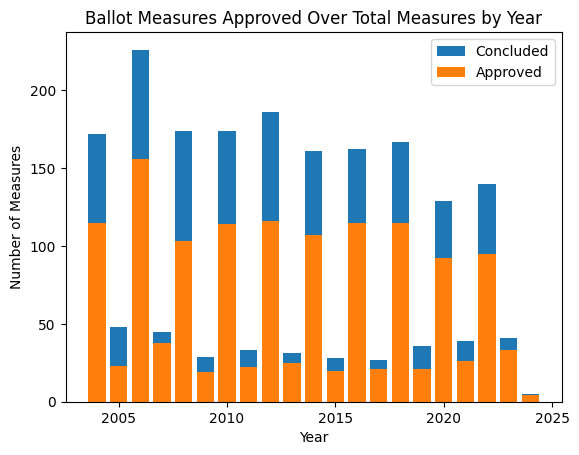

In [ ]:
print('Total share of measures passed:',
      ballot['Approved'].sum() / ballot['Concluded'].sum())

# plot bar chart of measures concluded and measures approved, by year
concluded_counts = ballot.groupby('Year')['Concluded'].sum()
approved_counts = ballot[ballot['Concluded'] == 1].groupby('Year')['Approved'].sum()

plt.bar(concluded_counts.index, concluded_counts, label = 'Concluded')
plt.bar(concluded_counts.index, approved_counts, label = 'Approved')
plt.xlabel('Year')
plt.ylabel('Number of Measures')
plt.title('Ballot Measures Approved Over Total Measures by Year')
plt.legend()
plt.show()

In [ ]:
ballot.drop(columns = ['Approved', 'Concluded'], inplace = True)

Average vote in favor: 0.5740984558395434


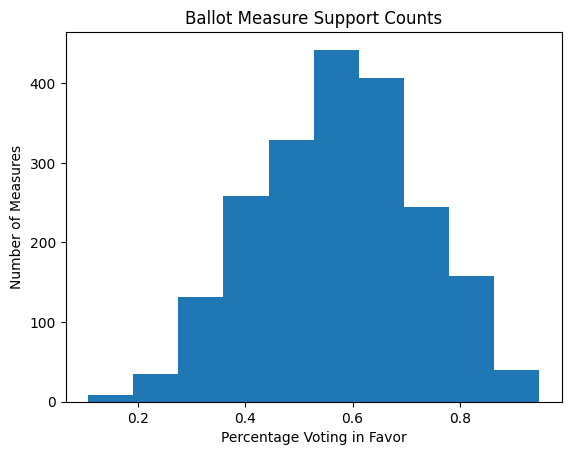

In [ ]:
print('Average vote in favor:', ballot['Yes_percent'].mean())

# histogram of ballot measure support
plt.hist(ballot['Yes_percent'], bins = 10)

plt.xlabel('Percentage Voting in Favor')
plt.ylabel('Number of Measures')
plt.title('Ballot Measure Support Counts')
plt.show()

Average roll-off: 0.027686331256636467


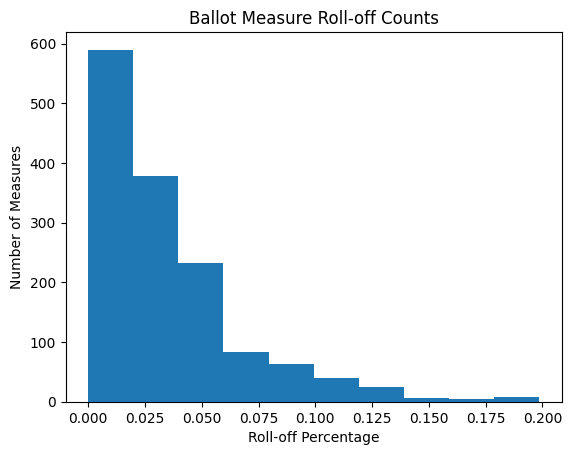

In [ ]:
print('Average roll-off:', ballot['Rolloff'].mean())

# histogram of ballot measure roll-off
rolloff_rows = ballot[(ballot['Rolloff'] > 0) & (ballot['Rolloff'] < .2)]
plt.hist(rolloff_rows['Rolloff'], bins = 10)

plt.xlabel('Roll-off Percentage')
plt.ylabel('Number of Measures')
plt.title('Ballot Measure Roll-off Counts')
plt.show()

Type
LRCA          1133
CISS           248
CICA           214
BI             143
LRSS           101
IndISS          88
VR              59
AQ              54
ITP             35
LBM             25
CICA/SS         24
ABR             16
ITL             15
CR              15
IndICA           5
ConCon           4
AQs              3
CCQ              1
Referendum       1
Name: count, dtype: Int64


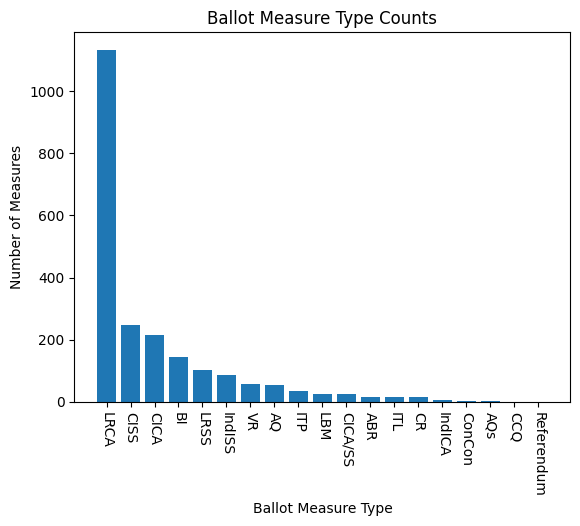

In [ ]:
# plot bar chart of ballot measure types
type_counts = ballot['Type'].value_counts()
print(type_counts)

plt.bar(type_counts.index, type_counts.values)
plt.xlabel('Ballot Measure Type')
plt.ylabel('Number of Measures')
plt.xticks(rotation = -90)
plt.title('Ballot Measure Type Counts')
plt.show()

Average number of measures on ballot: 7.303113553113553


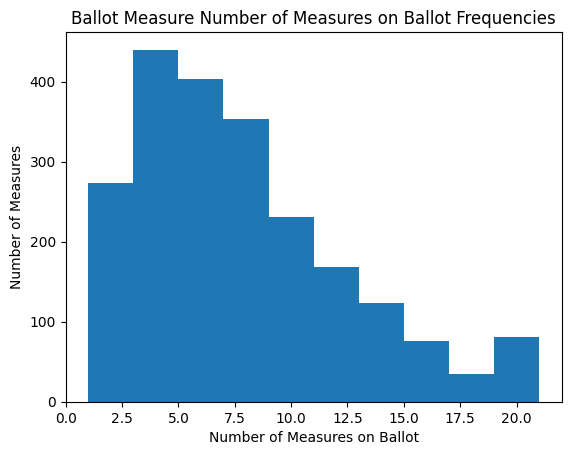

In [ ]:
print('Average number of measures on ballot:', ballot['Races_on_ballot'].mean())

# histogram of number of races on ballot
plt.hist(ballot['Races_on_ballot'], bins = 10)

plt.xlabel('Number of Measures on Ballot')
plt.ylabel('Number of Measures')
plt.title('Ballot Measure Number of Measures on Ballot Frequencies')
plt.show()

Average dollars in support per 10,000 residents: 4831.139383507375
Average dollars in opposition per 10,000 residents: 3302.305773599087


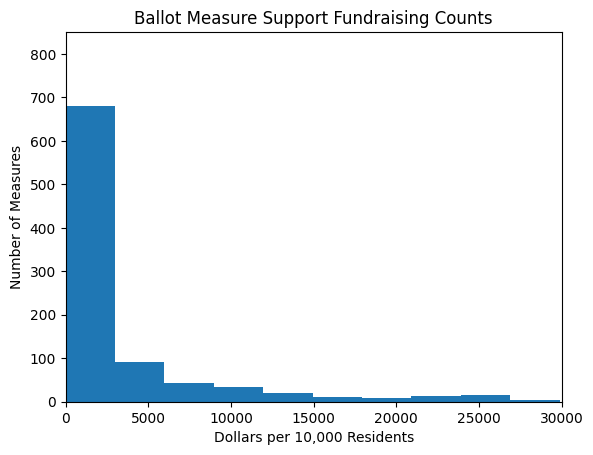

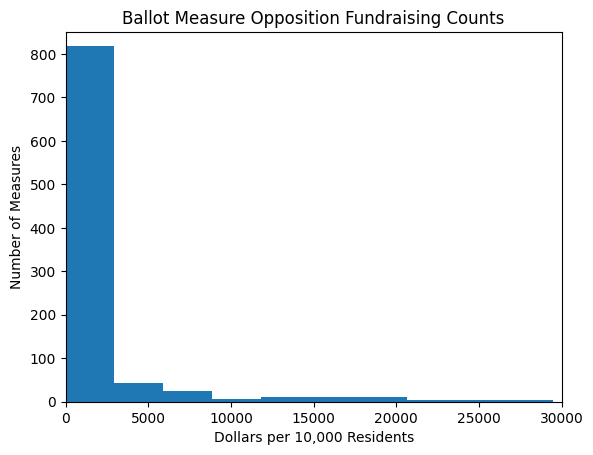

In [ ]:
print('Average dollars in support per 10,000 residents:',
      ballot['Support_dollars_per_capita'].mean() * 10000)
print('Average dollars in opposition per 10,000 residents:',
      ballot['Oppose_dollars_per_capita'].mean() * 10000)

support_rows = ballot[ballot['Support_dollars_per_capita'] < 3]
oppose_rows = ballot[ballot['Oppose_dollars_per_capita'] < 3]

# histogram of dollars spent supporting each measure per 10,000 residents
plt.hist(support_rows['Support_dollars_per_capita'] * 10000, bins = 10)

plt.xlim([0, 30000])
plt.ylim([0, 850])
plt.xlabel('Dollars per 10,000 Residents')
plt.ylabel('Number of Measures')
plt.title('Ballot Measure Support Fundraising Counts')
plt.show()

# histogram of dollars spent opposing each measure per 10,000 residents
plt.hist(oppose_rows['Oppose_dollars_per_capita'] * 10000, bins = 10)

plt.xlim([0, 30000])
plt.ylim([0, 850])
plt.xlabel('Dollars per 10,000 Residents')
plt.ylabel('Number of Measures')
plt.title('Ballot Measure Opposition Fundraising Counts')
plt.show()

Proportion of races with uncontested fundraising: 0.22164412070759626
Average difference in support and oppose dollars per 10,000 residents: 2230.988390089339


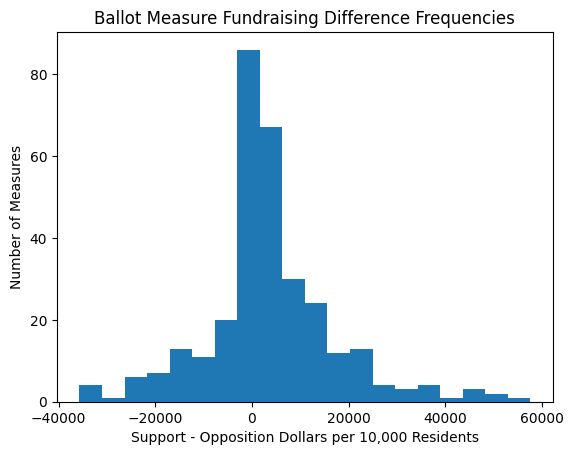

In [ ]:
not_na_dollars = ballot[ballot['Support_dollars_per_capita'].notna() +
                        ballot['Oppose_dollars_per_capita'].notna()]
no_support_dollars = ballot[(ballot['Support_dollars_per_capita'] <= 0) &
 (ballot['Oppose_dollars_per_capita'] > 0)]
no_oppose_dollars = ballot[(ballot['Support_dollars_per_capita'] > 0) &
 (ballot['Oppose_dollars_per_capita'] <= 0)]
print('Proportion of races with uncontested fundraising:',
 (len(no_support_dollars) + len(no_oppose_dollars)) / len(not_na_dollars))

non_zero_dollars = ballot[(ballot['Support_dollars_per_capita'] > 0) &
 (ballot['Oppose_dollars_per_capita'] > 0)]
dollar_diffs = non_zero_dollars['Support_dollars_per_capita'] -
non_zero_dollars['Oppose_dollars_per_capita']
print('Average difference in support and oppose dollars per 10,000 residents:',
      dollar_diffs.mean() * 10000)

diff_rows = dollar_diffs[(dollar_diffs < 6) & (dollar_diffs > -5)]

# histogram of difference in support and oppose dollars
plt.hist(diff_rows * 10000, bins = 20)

plt.xlabel('Support - Opposition Dollars per 10,000 Residents')
plt.ylabel('Number of Measures')
plt.title('Ballot Measure Fundraising Difference Frequencies')
plt.show()

Average number of measures per state: 44.57142857142857
State
CA    170
LA    137
CO    116
WA    113
TX    104
CT      7
IA      7
MN      6
IN      6
VT      3
Name: count, dtype: Int64


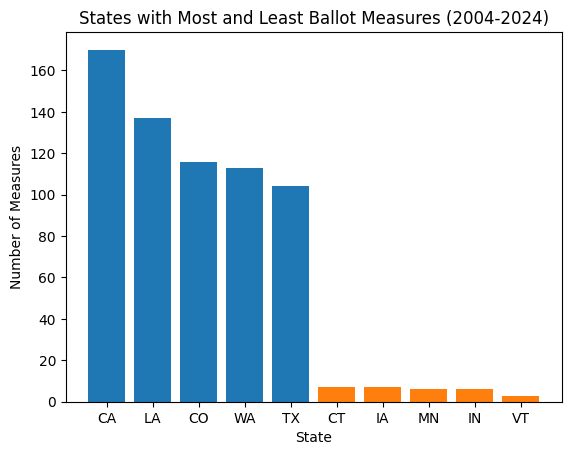

In [ ]:
# plot bar chart of states with most and least ballot measures
state_counts = ballot['State'].value_counts().sort_values(ascending = False)
print('Average number of measures per state:', state_counts.mean())

# extract top 5 and lowest 5 states
top_5_states = state_counts.head(5)
bottom_5_states = state_counts.tail(5)
combined_states = pd.concat([top_5_states, bottom_5_states])
print(combined_states)

plt.bar(combined_states.index, combined_states.values,
        color = [plt.cm.tab10.colors[0]] * 5 + [plt.cm.tab10.colors[1]] * 5)

plt.xlabel('State')
plt.ylabel('Number of Measures')
plt.title('States with Most and Least Ballot Measures (2004-2024)')
plt.show()

Average number of words: 126.20526630760024


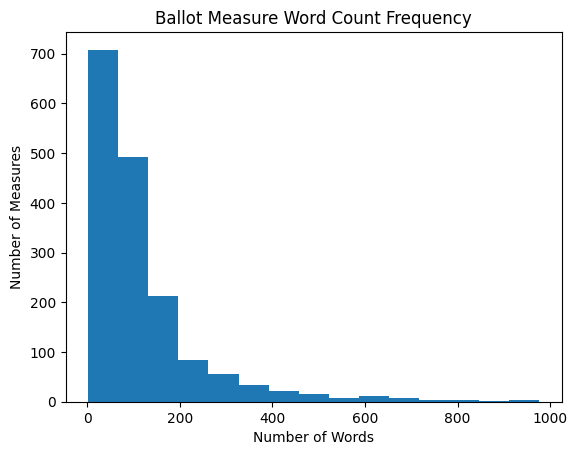

In [ ]:
print('Average number of words:', ballot['text_len'].mean())

# histogram of ballot text length
len_rows = ballot[ballot['text_len'] < 1000]
plt.hist(len_rows['text_len'], bins = 15)

plt.xlabel('Number of Words')
plt.ylabel('Number of Measures')
plt.title('Ballot Measure Word Count Frequency')
plt.show()

{'Is Question': 0.36385397965290245, 'Has Multiple Sentences': 0.6253740275284261, 'Has Fiscal Statement': 0.07005494505494506}


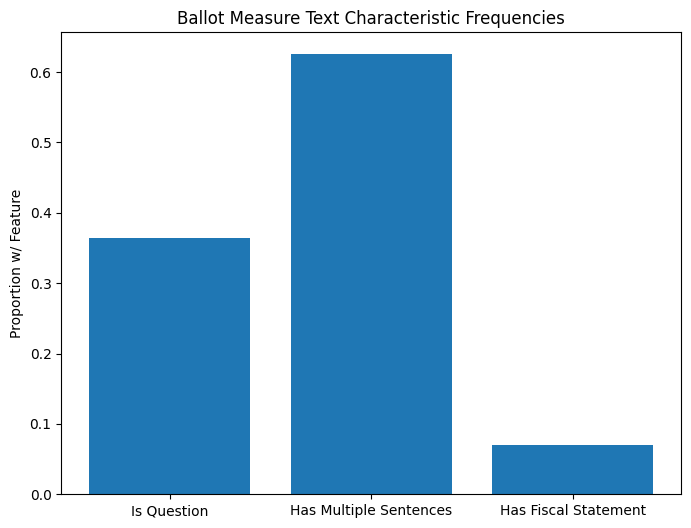

In [ ]:
# plot bar chart of ballot measure text characteristics
yes_props = {'Is Question': ballot['is_question'].mean(),
             'Has Multiple Sentences': ballot['is_multi_sentence'].mean(),
             'Has Fiscal Statement': ballot['has_fiscal'].mean()
             }

print(yes_props)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(yes_props.keys(), yes_props.values())

ax.set_ylabel('Proportion w/ Feature')
ax.set_title('Ballot Measure Text Characteristic Frequencies')
plt.show()

Average Flesch-Kincaid grade level: 25.066561014263076
Share of measures with Flesch-Kincaid grade >= 12: 0.9160063391442155
Share of measures with Flesch-Kincaid grade >= 16: 0.6275752773375595


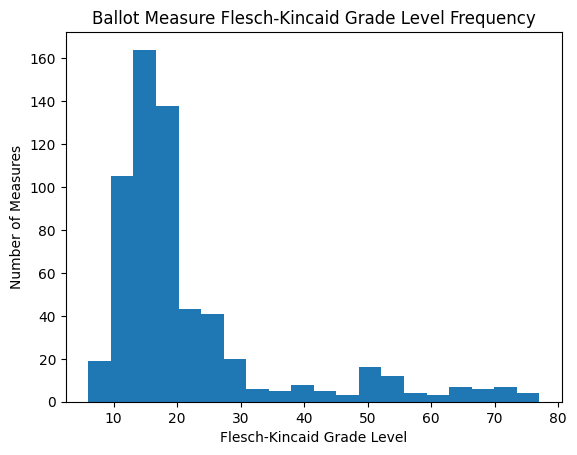

In [ ]:
print('Average Flesch-Kincaid grade level:', ballot['fk_grade'].mean())
clean_fk_grade = ballot.loc[ballot['fk_grade'].notna(), 'fk_grade']
print('Share of measures with Flesch-Kincaid grade >= 12:', (clean_fk_grade >= 12).mean())
print('Share of measures with Flesch-Kincaid grade >= 16:', (clean_fk_grade >= 16).mean())

# fk_grade
fk_rows = ballot[ballot['fk_grade'] < 80]

plt.hist(fk_rows['fk_grade'], bins = 20)

plt.xlabel('Flesch-Kincaid Grade Level')
plt.ylabel('Number of Measures')
plt.title('Ballot Measure Flesch-Kincaid Grade Level Frequency')
plt.show()

Taxes             329.0
Governance        270.0
Social Policy     203.0
Bonds             178.0
Voting            174.0
Finance           127.0
Crime             124.0
Economy            93.0
Environment        92.0
Gambling           77.0
Judicial           76.0
Civil Rights       71.0
Property           59.0
Infrastructure     54.0
dtype: float64


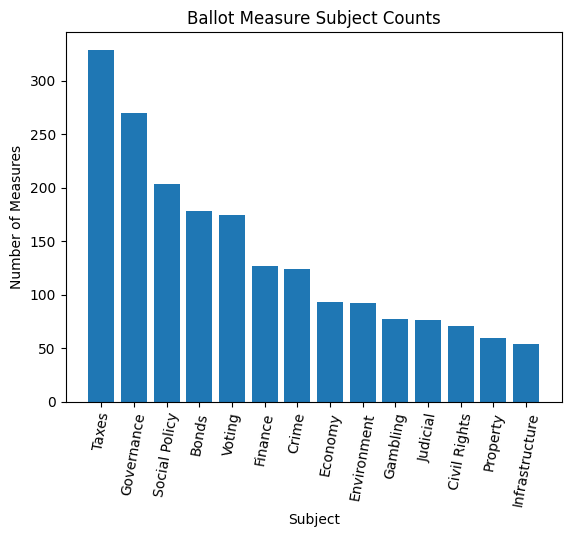

In [ ]:
# create table of ballot measure counts by subject
ballot_subjects = ['Bonds', 'Civil_rights', 'Crime', 'Economy', 'Environment',
                   'Finance', 'Gambling', 'Governance', 'Infrastructure',
                   'Judicial', 'Property', 'Social_policy', 'Taxes', 'Voting']
subject_counts = ballot[ballot_subjects].sum()
subject_counts.index = ['Bonds', 'Civil Rights', 'Crime', 'Economy', 'Environment',
                        'Finance', 'Gambling', 'Governance', 'Infrastructure',
                        'Judicial', 'Property', 'Social Policy', 'Taxes', 'Voting']
subject_counts.sort_values(ascending = False, inplace = True)
print(subject_counts)

# plot bar chart of ballot measures by subject
plt.bar(subject_counts.index, subject_counts.values)
plt.xlabel('Subject')
plt.ylabel('Number of Measures')
plt.xticks(rotation = 80)
plt.title('Ballot Measure Subject Counts')
plt.show()

state
TN    0.950110
SC    0.840271
AR    0.823921
TX    0.783642
MS    0.782648
VT   -0.666416
ID   -0.696028
ME   -1.310320
ND   -1.441896
OR   -1.727171
Name: COVI, dtype: float64


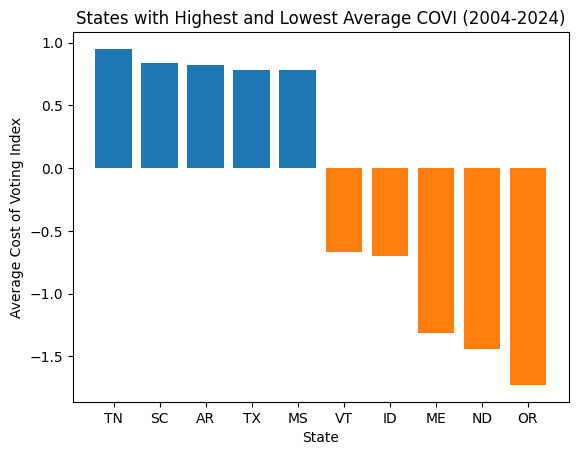

In [ ]:
# plot bar chart of states with highest and lowest average cost of voting index
state_means = covi.groupby('state')['COVI'].mean().sort_values(ascending = False)

# extract top 5 and lowest 5 states
top_5_covi = state_means.head(5)
bottom_5_covi = state_means.tail(5)
combined_covi = pd.concat([top_5_covi, bottom_5_covi])
print(combined_covi)

plt.bar(combined_covi.index, combined_covi.values,
        color = [plt.cm.tab10.colors[0]] * 5 + [plt.cm.tab10.colors[1]] * 5)

plt.xlabel('State')
plt.ylabel('Average Cost of Voting Index')
plt.title('States with Highest and Lowest Average COVI (2004-2024)')
plt.show()

### Correlations

In [ ]:
# identify features correlated with measure support
ballot_corr = ballot.corr(numeric_only = True)
support_corr = ballot_corr['Yes_percent'].sort_values(ascending = False)
support_corr[abs(support_corr) >= .1]

,Yes_percent
Yes_percent,1.000000
Black or African American,0.180487
COVI,0.165119
White,-0.100438
is_multi_sentence,-0.102067
text_len,-0.102550
American Indian and Alaska Native,-0.109023
Support_dollars_per_capita,-0.111263
Turnout,-0.124198
Oppose_dollars_per_capita,-0.140165


In [ ]:
# identify features correlated with roll-off
ballot_corr = ballot.corr(numeric_only = True)
rolloff_corr = ballot_corr['Rolloff'].sort_values(ascending = False)
rolloff_corr[abs(support_corr) >= .08]

,Rolloff
Black or African American,0.138458
Partisanship,0.019726
Family households,0.015341
is_multi_sentence,0.014756
Turnout,0.013546
COVI,-0.002171
Yes_percent,-0.007814
American Indian and Alaska Native,-0.028791
text_len,-0.037743
Bonds,-0.069855


## **Machine Learning Models**

First, I create baseline models against which I compare predictive performance. I build a gradient-boosted tree for both the ballot measure support and roll-off outcome variables to derive high-importance predictors. These predictors comprise one of several regression models I run for each outcome variable to identify significant features that influence ballot measure vote outcomes.

In [ ]:
ballot = pd.read_csv('ballot.csv', dtype = {
    'Year': 'float64', 'State': 'string', 'Title': 'string', 'Type': 'string',
    'Concluded': 'float64', 'Approved': 'float64', 'text_len': 'float64',
    'is_question': 'float64', 'is_multi_sentence': 'float64', 'has_fiscal': 'float64',
    'fk_grade': 'float64', 'COVI': 'float64', 'Partisanship': 'float64',
    'Turnout': 'float64', 'Total population': 'float64',
    'Median age (years)': 'float64', 'White': 'float64',
    'Black or African American': 'float64',
    'American Indian and Alaska Native': 'float64', 'Asian' : 'float64',
    'Hispanic or Latino (of any race)': 'float64', 'Male_to_female': 'float64',
    'Housing units per capita': 'float64', 'Family households': 'float64',
    'Married': 'float64', 'Enrolled in school': 'float64',
    "Bachelor's degree or higher": 'float64', 'Civilian veteran': 'float64',
    'Has disability': 'float64', 'Language other than English': 'float64',
    'Speak English less than "very well"': 'float64', 'In labor force': 'float64',
    'Median household income (dollars)': 'float64', 'Per capita income (dollars)': 'float64',
    'No health insurance coverage': 'float64', 'In poverty': 'float64',
    'Support_dollars_per_capita': 'float64', 'Oppose_dollars_per_capita': 'float64',
    'Total_dollars_per_capita': 'float64', 'Bonds': 'float64', 'Civil_rights': 'float64',
    'Crime': 'float64', 'Economy': 'float64', 'Environment': 'float64',
    'Finance': 'float64', 'Gambling': 'float64', 'Governance': 'float64',
    'Infrastructure': 'float64', 'Judicial': 'float64', 'Property': 'float64',
    'Social_policy': 'float64', 'Taxes': 'float64', 'Voting': 'float64',
    'Yes_percent': 'float64', 'Rolloff': 'float64', 'Races_on_ballot': 'float64'})

# drop non-predictive variables
ballot.drop(columns = ['Approved', 'Concluded', 'Title'], inplace = True)

In [ ]:
# find all categorical variables
ballot.select_dtypes(include = 'string').columns

Index(['State', 'Type'], dtype='object')

In [ ]:
# convert state and measure type variables to category for XGBoost
ballot['State'] = ballot['State'].astype('category')
ballot['Type'] = ballot['Type'].astype('category')

In [ ]:
# reinstalling earlier version of scikit-learn for XGBoost compatibility
# !pip uninstall scikit-learn
# !pip install scikit-learn==1.5.2

### Baseline Models

The below baseline models always predict the mean value for each of the ballot measure support and roll-off outcome variables.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# baseline model for ballot support prediction
# extract feature and target data
X_sup = ballot[ballot['Yes_percent'].notna()].drop(columns = ['Yes_percent'])
y_sup = ballot[ballot['Yes_percent'].notna()]['Yes_percent']

# split data into training and testing sets
X_train_sup, X_test_sup, y_train_sup, y_test_sup = train_test_split(X_sup, y_sup, test_size = 0.2)

# root mean squared error for always guessing mean
mean_prediction = [y_train_sup.mean()] * len(y_test_sup)
print('Mean RMSE: %g' % np.sqrt(mean_squared_error(y_test_sup, mean_prediction)))

Mean RMSE: 0.154689


**Mean RMSE:** 0.154689

In [ ]:
# baseline model for ballot roll-off prediction
# extract feature and target data
X_rol = ballot[ballot['Rolloff'].notna()].drop(columns = ['Rolloff'])
y_rol = ballot[ballot['Rolloff'].notna()]['Rolloff']

# split data into training and testing sets
X_train_rol, X_test_rol, y_train_rol, y_test_rol = train_test_split(X_rol, y_rol, test_size = 0.2)

# root mean squared error for always guessing mean
mean_prediction = [y_train_rol.mean()] * len(y_test_rol)
print('Mean RMSE: %g' % np.sqrt(mean_squared_error(y_test_rol, mean_prediction)))

Mean RMSE: 0.0374667


**Mean RMSE:** 0.0374667

### Gradient Boosted Tree

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

#### Ballot Measure Support Model

In [ ]:
# initialize training and testing sets
dtrain = xgb.DMatrix(X_train_sup, label = y_train_sup, enable_categorical = True)
dtest = xgb.DMatrix(X_test_sup, label = y_test_sup, enable_categorical = True)

# initialize XGBoost regression model
model = xgb.XGBRegressor(objective = 'reg:squarederror', eval_metric = 'rmse')

# define parameter grid for cross-validation tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'enable_categorical': [True]}

# initialize 10-fold cross-validation of XGBoost regressor
gs_xgb = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5,
                      scoring = 'neg_mean_squared_error', n_jobs = -1,
                      error_score = 'raise')

In [ ]:
# fit model and return best hyperparameters/root mean squared error
gs_xgb.fit(X_train_sup, y_train_sup)
print(f'Best Parameters: {gs_xgb.best_params_}')
print(f'Best Root Mean Squared Error: {np.sqrt(-gs_xgb.best_score_)}')

Best Parameters: {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Root Mean Squared Error: 0.12752830061311196


**Best Parameters:** {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

**Best Root Mean Squared Error:** 0.12827183514122467

Training RMSE: 0.10045583250271016
Testing RMSE: 0.1290779270775661
Training R²: 0.5467780760467164
Testing R²: 0.3017411719323937


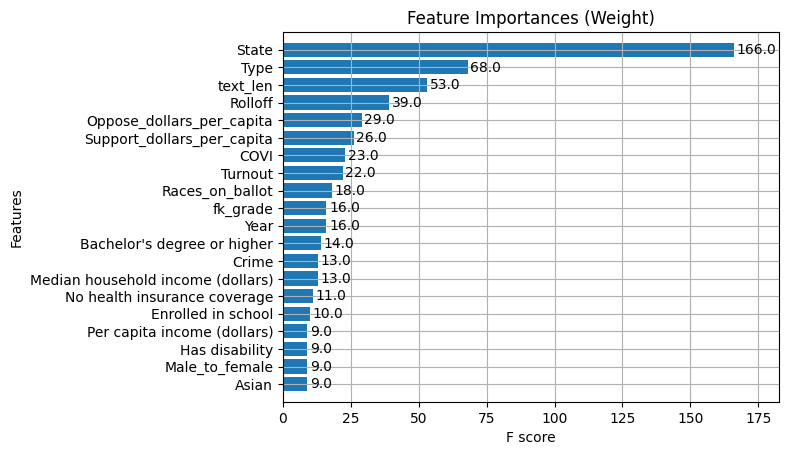

In [ ]:
from sklearn.metrics import r2_score

# train model with optimal parameters
best_params = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3,
               'subsample': 0.8}
model = xgb.train(best_params, dtrain, num_boost_round = 100)

# make predictions
y_train_pred = model.predict(dtrain)
y_test_pred = model.predict(dtest)

# print RMSE for training and testing sets
print('Training RMSE:', np.sqrt(mean_squared_error(y_train_sup, y_train_pred)))
print('Testing RMSE:', np.sqrt(mean_squared_error(y_test_sup, y_test_pred)))

# print R² for training and testing sets
print('Training R²:', r2_score(y_train_sup, y_train_pred))
print('Testing R²:', r2_score(y_test_sup, y_test_pred))

# plot feature importances
xgb.plot_importance(model, importance_type = 'weight', max_num_features = 20, height = 0.8)
plt.title('Feature Importances (Weight)')
plt.show()

**Training RMSE:** 0.10045583250271016

**Testing RMSE:** 0.1290779270775661

**Training R²:** 0.5467780760467164

**Testing R²:** 0.3017411719323937

In [ ]:
# extract feature importances
support_importances = model.get_score(importance_type = 'weight')  # Or 'gain', 'cover', etc.
support_importances = sorted(support_importances.items(), key = lambda x: x[1], reverse = True)
support_importances = pd.DataFrame(support_importances, columns = ['Feature', 'Importance'])
support_importances

,Feature,Importance
0,State,166.0
1,Type,68.0
2,text_len,53.0
3,Rolloff,39.0
4,Oppose_dollars_per_capita,29.0
5,Support_dollars_per_capita,26.0
6,COVI,23.0
7,Turnout,22.0
8,Races_on_ballot,18.0
9,Year,16.0


In [ ]:
support_importances.to_csv('support_importances.csv', index = False)

In [ ]:
# extract columns with greatest feature importance
important_cols = support_importances[support_importances['Importance'] >= 15]['Feature']
important_cols

,Feature
0,State
1,Type
2,text_len
3,Rolloff
4,Oppose_dollars_per_capita
5,Support_dollars_per_capita
6,COVI
7,Turnout
8,Races_on_ballot
9,Year


In [ ]:
# reinitialize model with most important columns
dtrain = xgb.DMatrix(X_train_sup[important_cols], label = y_train_sup, enable_categorical = True)
dtest = xgb.DMatrix(X_test_sup[important_cols], label = y_test_sup, enable_categorical = True)

# train model with optimal parameters and most important columns
reduced_model = xgb.train(best_params, dtrain, num_boost_round = 100)

# make predictions
y_train_pred = reduced_model.predict(dtrain)
y_test_pred = reduced_model.predict(dtest)

# print RMSE for training and testing sets
print('Training RMSE:', np.sqrt(mean_squared_error(y_train_sup, y_train_pred)))
print('Testing RMSE:', np.sqrt(mean_squared_error(y_test_sup, y_test_pred)))

# print R² for training and testing sets
print('Training R²:', r2_score(y_train_sup, y_train_pred))
print('Testing R²:', r2_score(y_test_sup, y_test_pred))

Training RMSE: 0.10373909810784204
Testing RMSE: 0.12971587976438956
Training R²: 0.5166680196510458
Testing R²: 0.2948219888757251


**Training RMSE:** 0.10373909810784204

**Testing RMSE:** 0.12971587976438956

**Training R²:** 0.5166680196510458

**Testing R²:** 0.2948219888757251

#### Ballot Measure Roll-off Model

In [ ]:
# initialize data into training and testing sets
dtrain = xgb.DMatrix(X_train_rol, label = y_train_rol, enable_categorical = True)
dtest = xgb.DMatrix(X_test_rol, label = y_test_rol, enable_categorical = True)

# initialize XGBoost regression model
model = xgb.XGBRegressor(objective = 'reg:squarederror', eval_metric = 'rmse')

# define parameter grid for cross-validation tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'enable_categorical': [True]}

# initialize 10-fold cross-validation of XGBoost regressor
gs_xgb = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5,
                      scoring = 'neg_mean_squared_error', n_jobs = -1,
                      error_score = 'raise')

In [ ]:
# fit model and return best hyperparameters/root mean squared error
gs_xgb.fit(X_train_rol, y_train_rol)
print(f'Best Parameters: {gs_xgb.best_params_}')
print(f'Best Root Mean Squared Error: {np.sqrt(-gs_xgb.best_score_)}')

Best Parameters: {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best Root Mean Squared Error: 0.02668206495329907


**Best Parameters:** {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

**Best Root Mean Squared Error:** 0.02668206495329907

Training RMSE: 0.017531117126154315
Testing RMSE: 0.028436511602170176
Training R²: 0.7610324634298795
Testing R²: 0.42357394269011206


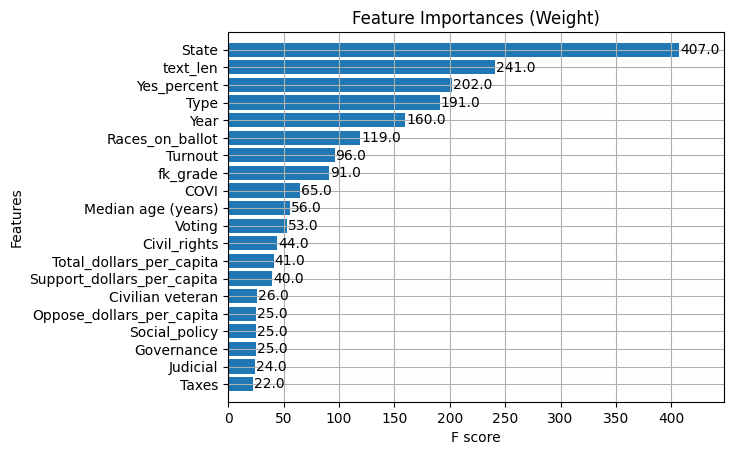

In [ ]:
# train model with optimal parameters
best_params = {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5,
               'subsample': 0.8}
model = xgb.train(best_params, dtrain, num_boost_round = 100)

# make predictions
y_train_pred = model.predict(dtrain)
y_test_pred = model.predict(dtest)

# print RMSE for training and testing sets
print('Training RMSE:', np.sqrt(mean_squared_error(y_train_rol, y_train_pred)))
print('Testing RMSE:', np.sqrt(mean_squared_error(y_test_rol, y_test_pred)))

# print R² for training and testing sets
print('Training R²:', r2_score(y_train_rol, y_train_pred))
print('Testing R²:', r2_score(y_test_rol, y_test_pred))

# plot feature importances
xgb.plot_importance(model, importance_type = 'weight', max_num_features = 20, height = 0.8)
plt.title('Feature Importances (Weight)')
plt.show()

**Training RMSE:** 0.017531117126154315

**Testing RMSE:** 0.028436511602170176

**Training R²:** 0.7610324634298795

**Testing R²:** 0.42357394269011206

In [ ]:
# extract feature importances
rolloff_importances = model.get_score(importance_type = 'weight')  # Or 'gain', 'cover', etc.
rolloff_importances = sorted(rolloff_importances.items(), key = lambda x: x[1], reverse = True)
rolloff_importances = pd.DataFrame(rolloff_importances, columns = ['Feature', 'Importance'])
rolloff_importances

,Feature,Importance
0,State,407.0
1,text_len,241.0
2,Yes_percent,202.0
3,Type,191.0
4,Year,160.0
5,Races_on_ballot,119.0
6,Turnout,96.0
7,fk_grade,91.0
8,COVI,65.0
9,Median age (years),56.0


In [ ]:
rolloff_importances.to_csv('rolloff_importances.csv', index = False)

In [ ]:
# extract columns with greatest feature importance
important_cols = rolloff_importances[rolloff_importances['Importance'] >= 50]['Feature']
important_cols

,Feature
0,State
1,text_len
2,Yes_percent
3,Type
4,Year
5,Races_on_ballot
6,Turnout
7,fk_grade
8,COVI
9,Median age (years)


In [ ]:
# reinitialize model with most important columns
dtrain = xgb.DMatrix(X_train_rol[important_cols], label = y_train_rol, enable_categorical = True)
dtest = xgb.DMatrix(X_test_rol[important_cols], label = y_test_rol, enable_categorical = True)

# train model with optimal parameters and reduced columns
reduced_model = xgb.train(best_params, dtrain, num_boost_round = 100)

# make predictions
y_train_pred = reduced_model.predict(dtrain)
y_test_pred = reduced_model.predict(dtest)

# print RMSE for training and testing sets
print('Training RMSE:', np.sqrt(mean_squared_error(y_train_rol, y_train_pred)))
print('Testing RMSE:', np.sqrt(mean_squared_error(y_test_rol, y_test_pred)))

# print R² for training and testing sets
print('Training R²:', r2_score(y_train_rol, y_train_pred))
print('Testing R²:', r2_score(y_test_rol, y_test_pred))

Training RMSE: 0.018223721911014994
Testing RMSE: 0.028680505777301097
Training R²: 0.7417776179027422
Testing R²: 0.41363967299401694


**Training RMSE:** 0.018223721911014994

**Testing RMSE:** 0.028680505777301097

**Training R²:** 0.7417776179027422

**Testing R²:** 0.41363967299401694

### Linear Regression

In [ ]:
import statsmodels.api as sm

#### Ballot Measure Support Regression

##### Regression Models

In [ ]:
# one-hot encode string variables for regression
X_sup = pd.get_dummies(X_sup, columns = ['State', 'Type'], drop_first = True)
X_sup = X_sup.astype(float)

# add constant for intercept
X_sup = sm.add_constant(X_sup)

# fit linear regression models
model = sm.OLS(y_sup, X_sup, missing = 'drop').fit()

model.summary()

In [ ]:
# check for rows with high number of NAs
X_sup.isna().sum()[X_sup.isna().sum() > 1000]

,0
fk_grade,1422
Support_dollars_per_capita,1092
Oppose_dollars_per_capita,1092
Total_dollars_per_capita,1092


In [ ]:
# model without Flesch-Kincaid grade level due to high NA rate
model2 = sm.OLS(y_sup, X_sup.drop(columns = 'fk_grade'), missing = 'drop').fit()
model2.summary()

In [ ]:
# model with only important columns from gradient boosted tree
support_importances = pd.read_csv('support_importances.csv')
important_cols = support_importances[support_importances['Importance'] > 15]['Feature']

# replace State and Type columns with one-hot encoded columns
state_type_cols = X_sup.columns[X_sup.columns.str.startswith('State') | X_sup.columns.str.startswith('Type')]
state_type_cols = pd.DataFrame({'Feature': state_type_cols})
important_cols = important_cols[~important_cols.isin(['State', 'Type'])]
important_cols = pd.concat([important_cols, state_type_cols])

X_sup3 = sm.add_constant(X_sup[list(important_cols['Feature'])])
model3 = sm.OLS(y_sup, X_sup3, missing = 'drop').fit()
model3.summary()

In [ ]:
from stargazer.stargazer import Stargazer

stargazer_sup = Stargazer([model, model2, model3])
stargazer_sup

In [ ]:
latex_sup = stargazer_sup.render_latex()

# rename coefficients
latex_sup = latex_sup.replace('text_len', 'Number of words')
latex_sup = latex_sup.replace('is_question', 'Is question')
latex_sup = latex_sup.replace('is_multi_sentence', 'Multiple sentences')
latex_sup = latex_sup.replace('has_fiscal', 'Fiscal statement')
latex_sup = latex_sup.replace('fk_grade', 'Flesch-Kincaid grade')
latex_sup = latex_sup.replace('State_', '')
latex_sup = latex_sup.replace('Type_', '')
latex_sup = latex_sup.replace('_', ' ')

latex_sup

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lccc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{3}{c}{\\textit{Dependent variable: Yes percent}} \\\n\\cr \\cline{2-4}\n\\\\[-1.8ex] & (1) & (2) & (3) \\\\\n\\hline \\\\[-1.8ex]\n American Indian and Alaska Native & 0.058$^{}$ & 0.030$^{}$ & \\\\\n& (0.177) & (0.081) & \\\\\n Asian & -0.060$^{}$ & -0.004$^{}$ & \\\\\n& (0.123) & (0.039) & \\\\\n Bachelor\'s degree or higher & 0.109$^{***}$ & 0.025$^{*}$ & \\\\\n& (0.032) & (0.014) & \\\\\n Black or African American & 0.139$^{}$ & 0.105$^{***}$ & \\\\\n& (0.100) & (0.038) & \\\\\n Bonds & 0.058$^{}$ & -0.030$^{}$ & \\\\\n& (0.075) & (0.035) & \\\\\n COVI & 0.061$^{}$ & -0.012$^{}$ & -0.006$^{}$ \\\\\n& (0.052) & (0.025) & (0.018) \\\\\n Civil rights & -0.078$^{}$ & -0.082$^{**}$ & \\\\\n& (0.060) & (0.038) & \\\\\n Civilian veteran & -0.065$^{}$ & -0.004$^{}$ & \\\\\n& (0.055) & (0.024) & \\\\\n Crime & 0.031$^{}$ & 0.036$^{}$ & \\\\\n& (0.036) &

In [ ]:
# display significant coeffcients for each regression
model1_sig = model.pvalues[model.pvalues < 0.05]
model2_sig = model2.pvalues[model2.pvalues < 0.05]
model3_sig = model3.pvalues[model3.pvalues < 0.05]

pd.DataFrame({'Model 1': model1_sig, 'Model 2': model2_sig, 'Model 3': model3_sig})

,Model 1,Model 2,Model 3
Bachelor's degree or higher,0.000904,NaN,NaN
Black or African American,NaN,0.005881,NaN
Civil_rights,NaN,0.032517,NaN
Judicial,NaN,0.031618,NaN
Oppose_dollars_per_capita,0.000943,0.034962,0.000015
State_KY,NaN,NaN,0.034145
Support_dollars_per_capita,0.004324,NaN,NaN
Turnout,NaN,0.009416,NaN
Type_BI,NaN,0.017237,0.046269
Type_LBM,NaN,0.008671,NaN


##### Verifying Linear Regression Assumptions

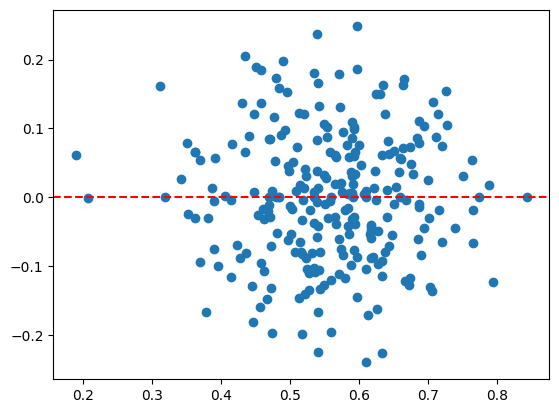

In [ ]:
# test assumptions for linear regression
# initialize predictions and residuals
y_pred = model.predict(X_sup)
residuals = y_sup - y_pred

# remove NAs
y_pred = y_pred[y_pred.notna()]
residuals = residuals[residuals.notna()]

# residual plot to verify linearity
plt.scatter(y_pred, residuals)
plt.axhline(0, color = 'red', linestyle = '--')
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Breusch-Pagan test for homoskedasticity (p > .05 indicates homoscedasticity)
_, p_value, _, _ = het_breuschpagan(residuals, X_sup.dropna())
print('Breusch-Pagan p-value:', p_value)

Breusch-Pagan p-value: 0.8758468084624275


In [ ]:
from statsmodels.stats.stattools import durbin_watson

# Durbin-Watson test for independence (value ~2 indicates independence)
print('Durbin-Watson:', durbin_watson(residuals))

Durbin-Watson: 2.209207904068897


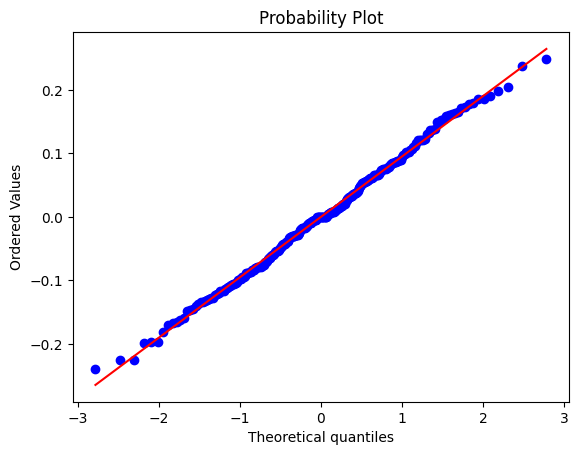

In [ ]:
import scipy.stats as stats

# Quantile-Quantile plot to verify residuals follows normal distribution
stats.probplot(residuals, dist = 'norm', plot = plt)
plt.show()

#### Ballot Measure Roll-Off Regression

##### Regression Models

In [ ]:
# one-hot encode string variables for regression
X_rol = pd.get_dummies(X_rol, columns = ['State', 'Type'], drop_first = True)
X_rol = X_rol.astype(float)

# add constant for intercept
X_rol = sm.add_constant(X_rol)

# fit linear regression model
model = sm.OLS(y_rol, X_rol, missing = 'drop').fit()

model.summary()

In [ ]:
# model without Flesch-Kincaid grade level due to high NA rate
model2 = sm.OLS(y_rol, X_rol.drop(columns = 'fk_grade'), missing = 'drop').fit()
model2.summary()

In [ ]:
# model with only important columns from gradient boosted tree
rolloff_importances = pd.read_csv('rolloff_importances.csv')
important_cols = rolloff_importances[rolloff_importances['Importance'] > 15]['Feature']

# replace State and Type columns with one-hot encoded columns
important_cols = important_cols[~important_cols.isin(['State', 'Type'])]
important_cols = pd.concat([important_cols, state_type_cols])

X_rol3 = sm.add_constant(X_rol[list(important_cols['Feature'])])
model3 = sm.OLS(y_rol, X_rol3, missing = 'drop').fit()
model3.summary()

In [ ]:
stargazer_rol = Stargazer([model, model2, model3])
stargazer_rol

In [ ]:
latex_rol = stargazer_rol.render_latex()

# rename coefficients
latex_rol = latex_rol.replace('text_len', 'Number of words')
latex_rol = latex_rol.replace('is_question', 'Is question')
latex_rol = latex_rol.replace('is_multi_sentence', 'Multiple sentences')
latex_rol = latex_rol.replace('has_fiscal', 'Fiscal statement')
latex_rol = latex_rol.replace('fk_grade', 'Flesch-Kincaid grade')
latex_rol = latex_rol.replace('State_', '')
latex_rol = latex_rol.replace('Type_', '')
latex_rol = latex_rol.replace('_', ' ')

latex_rol

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lccc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{3}{c}{\\textit{Dependent variable: Rolloff}} \\\n\\cr \\cline{2-4}\n\\\\[-1.8ex] & (1) & (2) & (3) \\\\\n\\hline \\\\[-1.8ex]\n American Indian and Alaska Native & 0.000$^{}$ & 0.007$^{}$ & \\\\\n& (0.042) & (0.017) & \\\\\n Asian & -0.026$^{}$ & -0.004$^{}$ & \\\\\n& (0.029) & (0.008) & \\\\\n Bachelor\'s degree or higher & -0.004$^{}$ & 0.001$^{}$ & -0.006$^{}$ \\\\\n& (0.008) & (0.003) & (0.007) \\\\\n Black or African American & -0.003$^{}$ & -0.004$^{}$ & \\\\\n& (0.024) & (0.008) & \\\\\n Bonds & -0.004$^{}$ & 0.003$^{}$ & \\\\\n& (0.018) & (0.008) & \\\\\n COVI & -0.002$^{}$ & 0.012$^{**}$ & -0.013$^{}$ \\\\\n& (0.012) & (0.005) & (0.010) \\\\\n Civil rights & -0.018$^{}$ & -0.015$^{*}$ & -0.017$^{}$ \\\\\n& (0.014) & (0.008) & (0.012) \\\\\n Civilian veteran & 0.002$^{}$ & -0.003$^{}$ & 0.005$^{}$ \\\\\n& (0.013) & (0.005) & (0.010) \\\\\n 

In [ ]:
# display significant coeffcients for each regression
model1_sig = model.pvalues[model.pvalues < 0.05]
model2_sig = model2.pvalues[model2.pvalues < 0.05]
model3_sig = model3.pvalues[model3.pvalues < 0.05]

pd.DataFrame({'Model 1': model1_sig, 'Model 2': model2_sig, 'Model 3': model3_sig})

,Model 1,Model 2,Model 3
COVI,NaN,2.553042e-02,NaN
Finance,NaN,3.643095e-02,NaN
Races_on_ballot,NaN,1.774728e-07,NaN
"Speak English less than ""very well""",NaN,2.506280e-02,NaN
Total population,NaN,4.261101e-03,NaN
Total_dollars_per_capita,NaN,1.529221e-02,NaN
Turnout,NaN,4.491169e-04,NaN
is_multi_sentence,0.013886,NaN,NaN


##### Verifying Linear Regression Assumptions

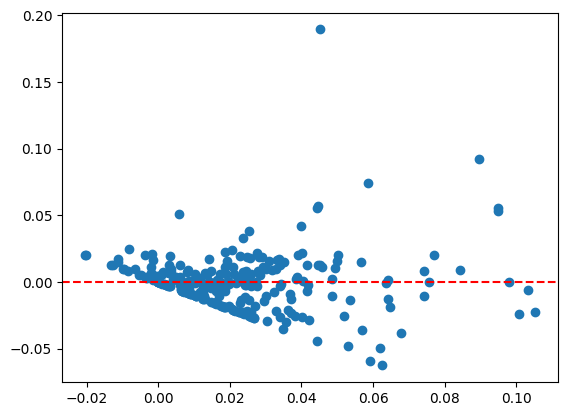

In [ ]:
# test assumptions for linear regression
# initialize predictions and residuals
y_pred = model.predict(X_rol)
residuals = y_rol - y_pred

# remove NAs
y_pred = y_pred[y_pred.notna()]
residuals = residuals[residuals.notna()]

# residual plot to verify linearity
plt.scatter(y_pred, residuals)
plt.axhline(0, color = 'red', linestyle = '--')
plt.show()

In [ ]:
# Breusch-Pagan test for homoskedasticity (p > .05 indicates homoscedasticity)
_, p_value, _, _ = het_breuschpagan(residuals, X_rol.dropna())
print('Breusch-Pagan p-value:', p_value)

Breusch-Pagan p-value: 0.9988340089687113


In [ ]:
# Durbin-Watson test for independence (value ~2 indicates independence)
print('Durbin-Watson:', durbin_watson(residuals))

Durbin-Watson: 1.9976402642119901


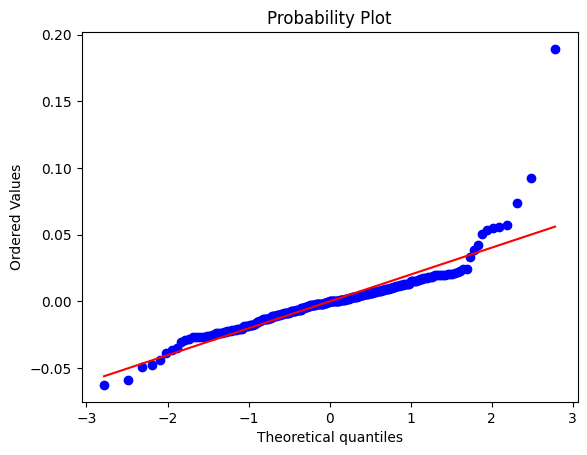

In [ ]:
# Quantile-Quantile plot to verify residuals follows normal distribution
stats.probplot(residuals, dist = 'norm', plot = plt)
plt.show()

## **Data Sources**

**Ballot Measure Data:**

Ballotpedia. n.d. “2004 ballot measures.” Ballotpedia. https://ballotpedia.org/2004_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2005 ballot measures.” Ballotpedia. https://ballotpedia.org/2005_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2006 ballot measures.” Ballotpedia. https://ballotpedia.org/2006_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2007 ballot measures.” Ballotpedia. https://ballotpedia.org/2007_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2008 ballot measures.” Ballotpedia. https://ballotpedia.org/2008_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2009 ballot measures.” Ballotpedia. https://ballotpedia.org/2009_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2010 ballot measures.” Ballotpedia. https://ballotpedia.org/2010_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2011 ballot measures.” Ballotpedia. https://ballotpedia.org/2011_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2012 ballot measures.” Ballotpedia. https://ballotpedia.org/2012_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2013 ballot measures.” Ballotpedia. https://ballotpedia.org/2013_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2014 ballot measures.” Ballotpedia. https://ballotpedia.org/2014_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2015 ballot measures.” Ballotpedia. https://ballotpedia.org/2015_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2016 ballot measures.” Ballotpedia. https://ballotpedia.org/2016_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2017 ballot measures.” Ballotpedia. https://ballotpedia.org/2017_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2018 ballot measures.” Ballotpedia. https://ballotpedia.org/2018_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2019 ballot measures.” Ballotpedia. https://ballotpedia.org/2019_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2020 ballot measures.” Ballotpedia. https://ballotpedia.org/2020_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2021 ballot measures.” Ballotpedia. https://ballotpedia.org/2021_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2022 ballot measures.” Ballotpedia. https://ballotpedia.org/2022_ballot_measures (December 30, 2024).

Ballotpedia. n.d. “2023 ballot measures.” Ballotpedia. https://ballotpedia.org/2023_ballot_measures (December 30, 2024).

Ballotpedia. 2024. “2024 ballot measures.” Ballotpedia. https://ballotpedia.org/2024_ballot_measures (December 30, 2024).

**Campaigan Finance Data:**

OpenSecrets. 2024. “Ballot Measures.” OpenSecrets. https://www.opensecrets.org/ballot-measures/ (December 30, 2024).

**Partisanship Data:**

Ballotpedia. 2024b. “Historical and potential changes in trifectas.” Ballotpedia. https://ballotpedia.org/Historical_and_potential_changes_in_trifectas (December 30, 2024).

Ballotpedia. 2024c. “Presidential voting history by state.” Ballotpedia. https://ballotpedia.org/Presidential_voting_history_by_state (December 30, 2024).

**Cost of Voting Index Data:**

Pomante II, Michael J. 2023. “Data Details.” Cost of Voting Index. https://costofvotingindex.com/data (December 30, 2024).

**Voter Turnout Data:**

Ballotpedia. 2024d. “Voter turnout in United States elections.” Ballotpedia. https://ballotpedia.org/Voter_turnout_in_United_States_elections (December 30, 2024).

**Demographic Data:**

United States Census Bureau. 2024. “DP05: ACS DEMOGRAPHIC AND HOUSING ESTIMATES.” Census Bureau Data. https://data.census.gov/table/ACSDP5Y2010.DP05 (December 30, 2024).

United States Census Bureau. 2024. “S0201: SELECTED POPULATION PROFILE IN THE UNITED STATES.” Census Bureau Data. https://data.census.gov/table/ACSSPP1Y2010.S0201 (December 30, 2024).